In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from dataclasses import dataclass
from matplotlib import rc
from matplotlib import colors
import matplotlib
plt.style.use('seaborn')
# Settings for generating LaTeX figures
USE_TEX = False
PRODUCTION = False
if USE_TEX:
    sns.set(rc={'text.usetex': True})
    tex_fonts = {
        "text.usetex": True,
        "font.family": "serif",
        "axes.labelsize": 10,
        "font.size": 10,
        "legend.fontsize": 8,
        "xtick.labelsize": 8,
        "ytick.labelsize": 8
    }
    plt.rcParams.update(tex_fonts)
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

In [2]:
@dataclass
class Cell:
    def __init__(self, max_age: int):
        self.max_age = max_age
        temp_age = np.random.normal(0.5 * self.max_age, 0.2)
        self.curr_age = 1 if temp_age < 0 else temp_age
        self.carbon_mass = 0
        self.cs_rate = 0.025
    
    def set_cs_rate(self, density: float):
        pass
    
    def set_mass(self):
        pass
    
    def get_cs(self):
        return self.cs_rate
        
    def grow(self):
        self.curr_age += 1
        # if self.curr_age > self.max_age:
        #     self.cut()
        if self.carbon_mass + self.cs_rate < 3:
            self.carbon_mass += self.cs_rate
        
    def get_mass(self) -> float:
        return self.carbon_mass
    
    def cut(self) -> None:
        self.curr_age = 1
        self.set_mass()

def csr_mat(x):
    return (6.37*x) - (14.27*x**2) + (8.31*x**3)

class TropicalCell(Cell):
    def __init__(self, max_age: int):
        self.max_age = max_age
        temp_age = np.random.normal(0.5 * self.max_age, 0.5 * self.max_age)
        self.curr_age = 1 if temp_age < 0 else temp_age
        self.flat_rate = 0
        
    def set_cs_rate(self, density: float):
        mat_dist = csr_mat( 0.5-((0.5-(self.curr_age/self.max_age)) / 1.1))
        mat = 0.4 - (0.4 - mat_dist)/3
        mu = (0.5 * np.pi *  40 * 43 / 2000)
        self.cs_rate = self.flat_rate + 0.1 *((mat * 0.5 * density) * np.random.normal(mu, 0.1 * mu))
    
    def set_mass(self):
        mu = (0.5 * np.pi * 40 * 43 / 2000) * (self.curr_age / self.max_age)
        self.carbon_mass = np.random.normal(mu, 0.1 * mu) 
        
class BorealCell(Cell):
    def __init__(self, max_age: int):
        self.max_age = max_age
        temp_age = np.random.normal(0.5 * self.max_age, 0.5 * self.max_age)
        self.curr_age = 1 if temp_age < 0 else temp_age
        self.flat_rate = 0
        
    def set_cs_rate(self, density: float):
        mat_dist = csr_mat( 0.5-((0.5-(self.curr_age/self.max_age)) / 1.1))
        mat = 0.4 - (0.4 - mat_dist)/3
        mu = (0.5 * np.pi * (1.5**2) * 80 * 34 / 2000)
        self.cs_rate = self.flat_rate + 0.5 *(mat * 0.5 * density) * np.random.normal(mu, 0.1 * mu)
    
    def set_mass(self):
        mu = (0.5 * np.pi * (1.5**2) * 80 * 34 / 2000) * (self.curr_age / self.max_age)
        self.carbon_mass = np.random.normal(mu, 0.1 * mu) 
        
class TemperateCell(Cell):
    def __init__(self, max_age: int):
        self.max_age = max_age
        temp_age = np.random.normal(0.5 * self.max_age, 0.5 * self.max_age)
        self.curr_age = 1 if temp_age < 0 else temp_age
        self.flat_rate = 0.05
        
    def set_cs_rate(self, density: float):
        mat_dist = csr_mat( 0.5-((0.5-(self.curr_age/self.max_age)) / 1.1))
        mat = 0.4 - (0.4 - mat_dist)/3
        mu = (0.5 * np.pi * (1.25**2) * 60 * 41 / 2000)
        self.cs_rate = self.flat_rate + 0.1 * (mat * 0.1 * density) * np.random.normal(mu, 0.1 * mu)
    
    def set_mass(self):
        mu = (0.5 * np.pi * (1.2**2) * 60 * 41 / 2000) * (self.curr_age / self.max_age)
        self.carbon_mass = np.random.normal(mu, 0.1 * mu)

Creating forests given inputs

In [7]:
@dataclass
class Forest:
    def __init__(self, land, size: int, max_time: int, maturity: str, plotting: bool, rho: float, m: float, management_rate: int, ftype: str):
        self.size = size
        self.maturity = maturity
        self.plotting = plotting
        self.max_time = max_time
        self.land = land
        self.ftype = ftype
        self.management_rate = management_rate
        self.rho = rho #density threshold
        self.m = m #mass threshold
#         self.atm_carbon = [] #carbon lost to atm
        self.tot_atm_carbon = []
        self.rmvd_carbon = [] #carbon removed per deforestation
        self.tot_rmvd_carbon = [] # cumulative carbon removed
        self.curr_carbon = [] #carbon currently in forest
        self.total_carbon = [] #total carbon sequestration
        self.curr_atm_release = [] 
        
    def simulate(self) -> None:
        p = .75
        q = 1-p
        for t in range(self.max_time):
            if t == 0:
                for (ii, ij) in np.ndindex(self.land.shape):
                    self.land[ii, ij].set_mass()
            if t % 10 == 0:
                if self.plotting == True:
                    self.plot_2d_mass(time=t)
                    plt.title('time:' + str(t))
            if t % self.management_rate == 0:                  
                curr_rmv = self.deforest()
                self.rmvd_carbon.append(p * curr_rmv)
                self.tot_rmvd_carbon.append(sum(self.rmvd_carbon))
                if self.plotting == True:
                    self.plot_2d_mass(time=t)
                    plt.title('cut time:' + str(t))
            rand_order = np.random.permutation([(x, y) for x in range(self.size) for y in range(self.size)])
            for (ii, ij) in rand_order:
                assert(isinstance(self.land[ii, ij], Cell))
                density = self.land[ii, ij].get_mass() / self.get_surrounding_density(ii, ij)
                self.land[ii, ij].set_cs_rate(density)
                self.land[ii, ij].grow()
            self.curr_carbon.append(self.get_curr_carbon_mass())
        self.total_carbon = [v + p * self.tot_rmvd_carbon[math.floor(i//self.management_rate)] for i, v in enumerate(self.curr_carbon)]
        self.total_atm_carbon = [q * self.tot_rmvd_carbon[math.floor(i//self.management_rate)] for i, v in enumerate(self.curr_carbon)]
        net_sequestration = [x-y for x, y in zip(self.total_carbon, self.total_atm_carbon)]

        fig, axes = plt.subplots(3,1, sharex=True, figsize=(6, 6))
        x = list(range(1, self.max_time + 1))
        sns.set_style(style = "darkgrid") 
        sns.lineplot(ax = axes[0], x=x, y=self.total_carbon, color='#81A1C1')
        sns.lineplot(ax = axes[1], x=x, y=self.total_atm_carbon, color='#81A1C1')
        sns.lineplot(ax = axes[2], x=x, y=net_sequestration, color='#81A1C1')
        if USE_TEX:
            plt.xlabel(r'$\mathrm{Time \ (yr)}$')
            axes[0].set(ylabel=r"$\mathrm{Total\ Carbon\ Sequestered \ (tC)}$")
            axes[1].set(ylabel=r"$\mathrm{Total\ Carbon\ Lost\ to\ Atmosphere\ (tC)}$")
            axes[2].set(ylabel=r"$\mathrm{Net\ Carbon\ Sequestration \ (tC)}$")
        else:
            plt.xlabel('Time (yr)')
            axes[0].set(ylabel='Total Carbon Sequestered')
            axes[1].set(ylabel='Total Carbon Lost to Atmosphere')
            axes[2].set(ylabel='Net Carbon Sequestration')
        axes[0].yaxis.get_label().set_fontsize(7)
        axes[1].yaxis.get_label().set_fontsize(7)
        axes[2].yaxis.get_label().set_fontsize(7)
        plt.suptitle('Carbon Levels Over Time',fontsize=15)
        fig.align_ylabels()
        plt.tight_layout(pad=2.0)
        if PRODUCTION:
            path = "./images/" + self.ftype + "_" + str(self.rho) + "_" + str(self.management_rate)
            plt.savefig(path + ".jpeg")
            with open(path+'.txt', 'w') as f:
                f.writelines(["Total Carbon Sequestration: " + str(self.total_carbon[-1]) + "\n", \
                             "Total Carbon Lost to Atmosphere: " + str(self.total_atm_carbon[-1]) + "\n", \
                             "Net Sequestration: " + str(self.total_carbon[-1] - self.total_atm_carbon[-1])])
        else:
            plt.show()
            print("Total Carbon Sequestration: " + str(self.total_carbon[-1]))
            print("Total Carbon Lost to Atmosphere: " + str(self.total_atm_carbon[-1]))
            print("Net Sequestration: " + str(self.total_carbon[-1] - self.total_atm_carbon[-1]))
        
    def deforest(self) -> int:
        curr_rmvd = 0
        rand_order = np.random.permutation([(x, y) for x in range(2,self.size - 2) for y in range(2,self.size - 2)])
        for (ii, ij) in rand_order:
            surr_mass = self.get_surrounding_density(ii, ij) * 8
            if surr_mass > self.rho: 
                for (ix, iy) in [(x, y) for x in range(ii - 1, ii + 2) for y in range(ij - 1, ij + 2)]:
                    curr_mass = self.land[ix, iy].get_mass()
                    if curr_mass > self.m:
                        rand = np.random.random()
                        if rand > .75:
                            self.land[ix, iy].cut()
                            curr_rmvd += curr_mass
        return curr_rmvd
        
    def get_surrounding_density(self, ii: int, ij: int) -> float:
        if ii == 0: 
            if ij == 0: #upper left corner
                return (self.land[ii + 1, ij].get_mass() + self.land[ii, ij + 1].get_mass() \
                       + self.land[ii + 1, ij + 1].get_mass()) / 3
            elif ij == self.size - 1: #upper right corner
                return (self.land[ii + 1, ij].get_mass() + self.land[ii, ij - 1].get_mass() \
                       + self.land[ii + 1, ij - 1].get_mass()) / 3
            else: #first row
                return (self.land[ii, ij - 1].get_mass() + self.land[ii, ij + 1].get_mass() \
                       + self.land[ii + 1, ij - 1].get_mass() + self.land[ii + 1, ij].get_mass() \
                       + self.land[ii + 1, ij + 1].get_mass()) / 5
        elif ii == self.size - 1:
            if ij == 0: #lower left corner
                return (self.land[ii - 1, ij].get_mass() + self.land[ii, ij + 1].get_mass() \
                       + self.land[ii - 1, ij - 1].get_mass()) / 3
            elif ij == self.size - 1: #lower right corner
                return (self.land[ii - 1, ij - 1].get_mass() + self.land[ii - 1, ij].get_mass() \
                       + self.land[ii, ij - 1].get_mass()) / 3
            else: #last row
                return (self.land[ii, ij - 1].get_mass() + self.land[ii, ij + 1].get_mass() \
                       + self.land[ii - 1, ij - 1].get_mass() + self.land[ii - 1, ij].get_mass() \
                       + self.land[ii - 1, ij + 1].get_mass()) / 5
        elif ij == 0: #first column
            return (self.land[ii - 1, ij].get_mass() + self.land[ii - 1, ij + 1].get_mass() \
                   + self.land[ii, ij + 1].get_mass() + self.land[ii + 1, ij].get_mass() \
                   + self.land[ii + 1, ij + 1].get_mass()) / 5
        elif ij == self.size - 1: #last column
            return (self.land[ii - 1, ij].get_mass() + self.land[ii - 1, ij - 1].get_mass() \
                   + self.land[ii, ij - 1].get_mass() + self.land[ii + 1, ij].get_mass() \
                   + self.land[ii + 1, ij - 1].get_mass()) / 5
        else: #middle cells
            return (self.land[ii - 1, ij - 1].get_mass() + self.land[ii - 1, ij].get_mass() \
                   + self.land[ii - 1, ij + 1].get_mass() + self.land[ii, ij - 1].get_mass() \
                   + self.land[ii, ij + 1].get_mass() + self.land[ii + 1, ij - 1].get_mass() \
                   + self.land[ii + 1, ij].get_mass() + self.land[ii + 1, ij + 1].get_mass()) / 8
                
    def get_curr_carbon_mass(self) -> int:
        return sum([self.land[ii, ij].get_mass() for (ii, ij) in np.ndindex(self.land.shape)])
    
    def plot_carbon(self, pl="TCS") -> None:
        self.simulate()
        fig, axes = plt.subplots(1, 2)
        curr_state = self.populate_state()
        sns.heatmap(curr_state, cmap="YlGnBu", ax=axes[0])
        x = list(range(1, self.max_time + 1))
        sns.set_style(style = 'whitegrid') 
        if pl == "TCS":
            sns.lineplot(ax = axes[1], x=x, y=self.total_carbon, color='#81A1C1')
            axes[1].set(xlabel='Time', ylabel='Total Carbon Sequestered')
        elif pl == "rmvd":
            x = list(range(1, self.max_time + 1, 10))
            axes[1] = sns.lineplot(x=x, y=self.rmvd_carbon, color='#81A1C1')
            axes[1].set(xlabel='Time', ylabel='Carbon Removed per Deforestation')
        elif pl == "tot_rmvd":
            x = list(range(1, self.max_time + 1, 10))
            axes[1] = sns.lineplot(x=x, y=self.tot_rmvd_carbon, color='#81A1C1')
            axes[1].set(xlabel='Time', ylabel='Total Carbon Removed')
        elif pl == "curr":
            axes[1] = sns.lineplot(x=x, y=self.curr_carbon, color='#81A1C1')
            axes[1].set(xlabel='Time', ylabel='Current Carbon Content')
        plt.xlim(0)
        plt.ylim(0)
        plt.show()
        print(self.total_carbon[-1])
        #plt.savefig("./images/" + self.ftype + "/cs.jpeg")
        
    def populate_state(self):
        ret = [[0 for _ in range(self.size)] for _ in range(self.size)]
        for i in range(self.size):
            for j in range(self.size):
                ret[i][j] = self.land[i, j].get_mass()   
        return ret
        
    def plot_2d_mass(self, time=0) -> None:
        curr_state = self.populate_state()
        ax = sns.heatmap(curr_state, cmap = 'crest', vmin = 0, vmax = 3, xticklabels=False, yticklabels=False)
        plt.show()
        
class Tropical(Forest):
    def __init__(self, size: int,max_time: int, maturity: str, plotting: bool, rho: float, m: float, management_rate: int, ftype="tropical"):
        super().__init__(np.array([[TropicalCell(np.random.normal(95, 15)) for _ in range(size)] for _ in range(size)]), \
                         size, max_time, maturity, plotting, rho, m, management_rate, ftype="tropical")
class Boreal(Forest):
    def __init__(self, size: int,max_time: int, maturity: str, plotting: bool, rho: float, m: float, management_rate: int, ftype="boreal"):
        super().__init__(np.array([[BorealCell(np.random.normal(150, 25)) for _ in range(size)] for _ in range(size)]), \
                         size, max_time, maturity, plotting, rho, m, management_rate, ftype="boreal")
        
class Temperate(Forest):
    def __init__(self, size: int,max_time: int, maturity: str, plotting: bool, rho: float, m: float, management_rate: int, ftype="temperate"):
        super().__init__(np.array([[BorealCell(np.random.normal(110, 20)) for _ in range(size)] for _ in range(size)]), \
                         size, max_time, maturity, plotting, rho, m, management_rate, ftype="temperate")

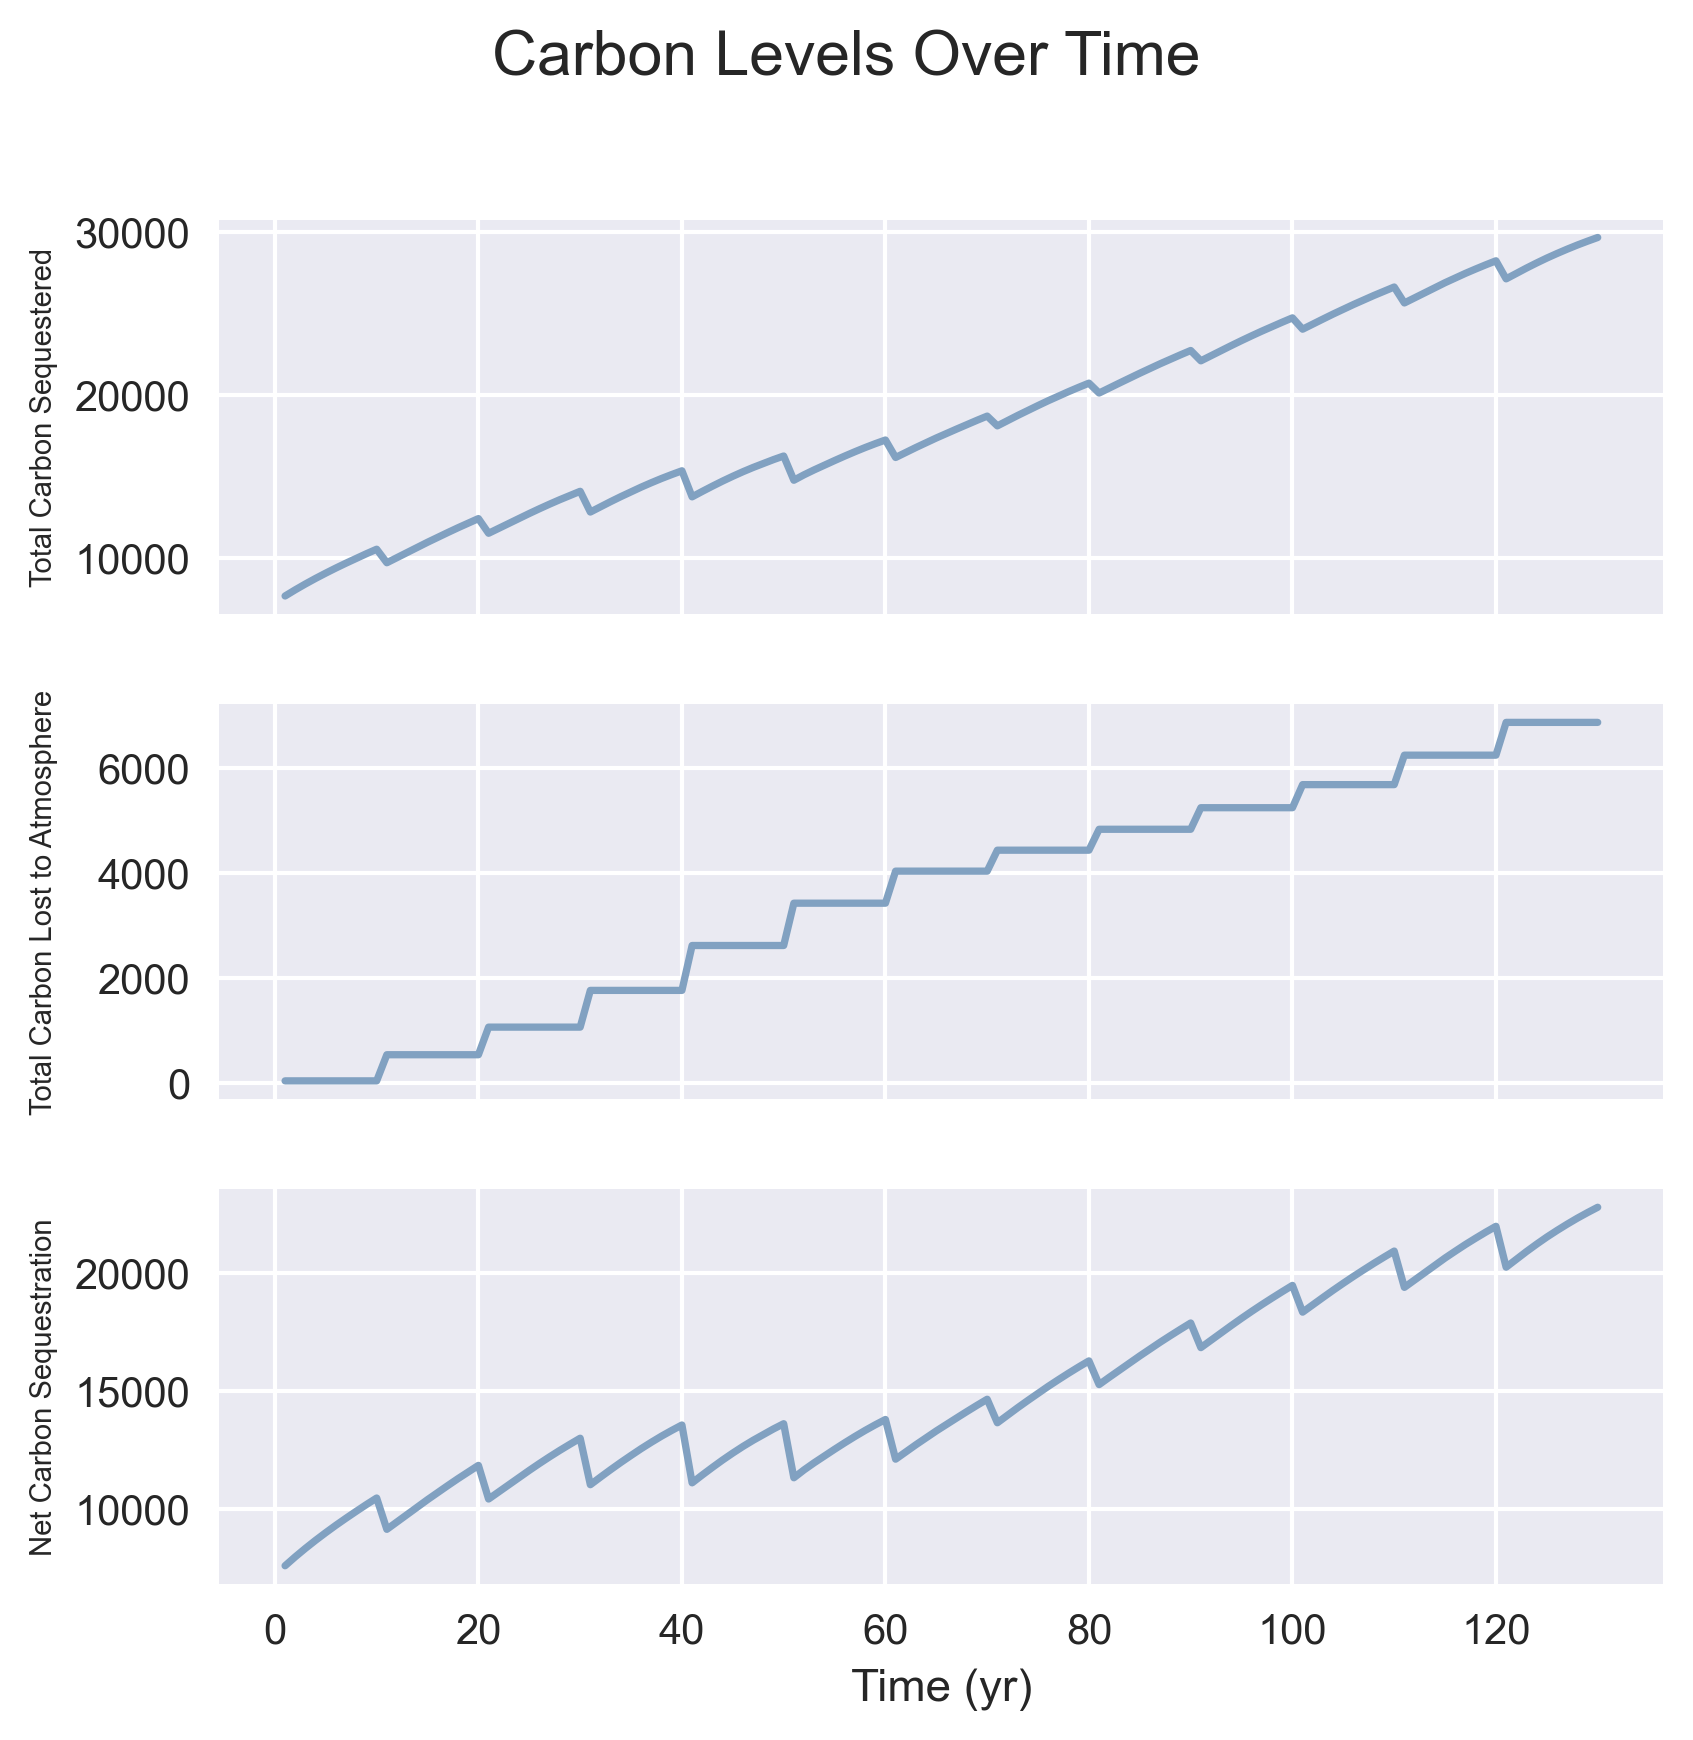

Total Carbon Sequestration: 29652.056634340144
Total Carbon Lost to Atmosphere: 6858.116387345932
Net Sequestration: 22793.940246994214


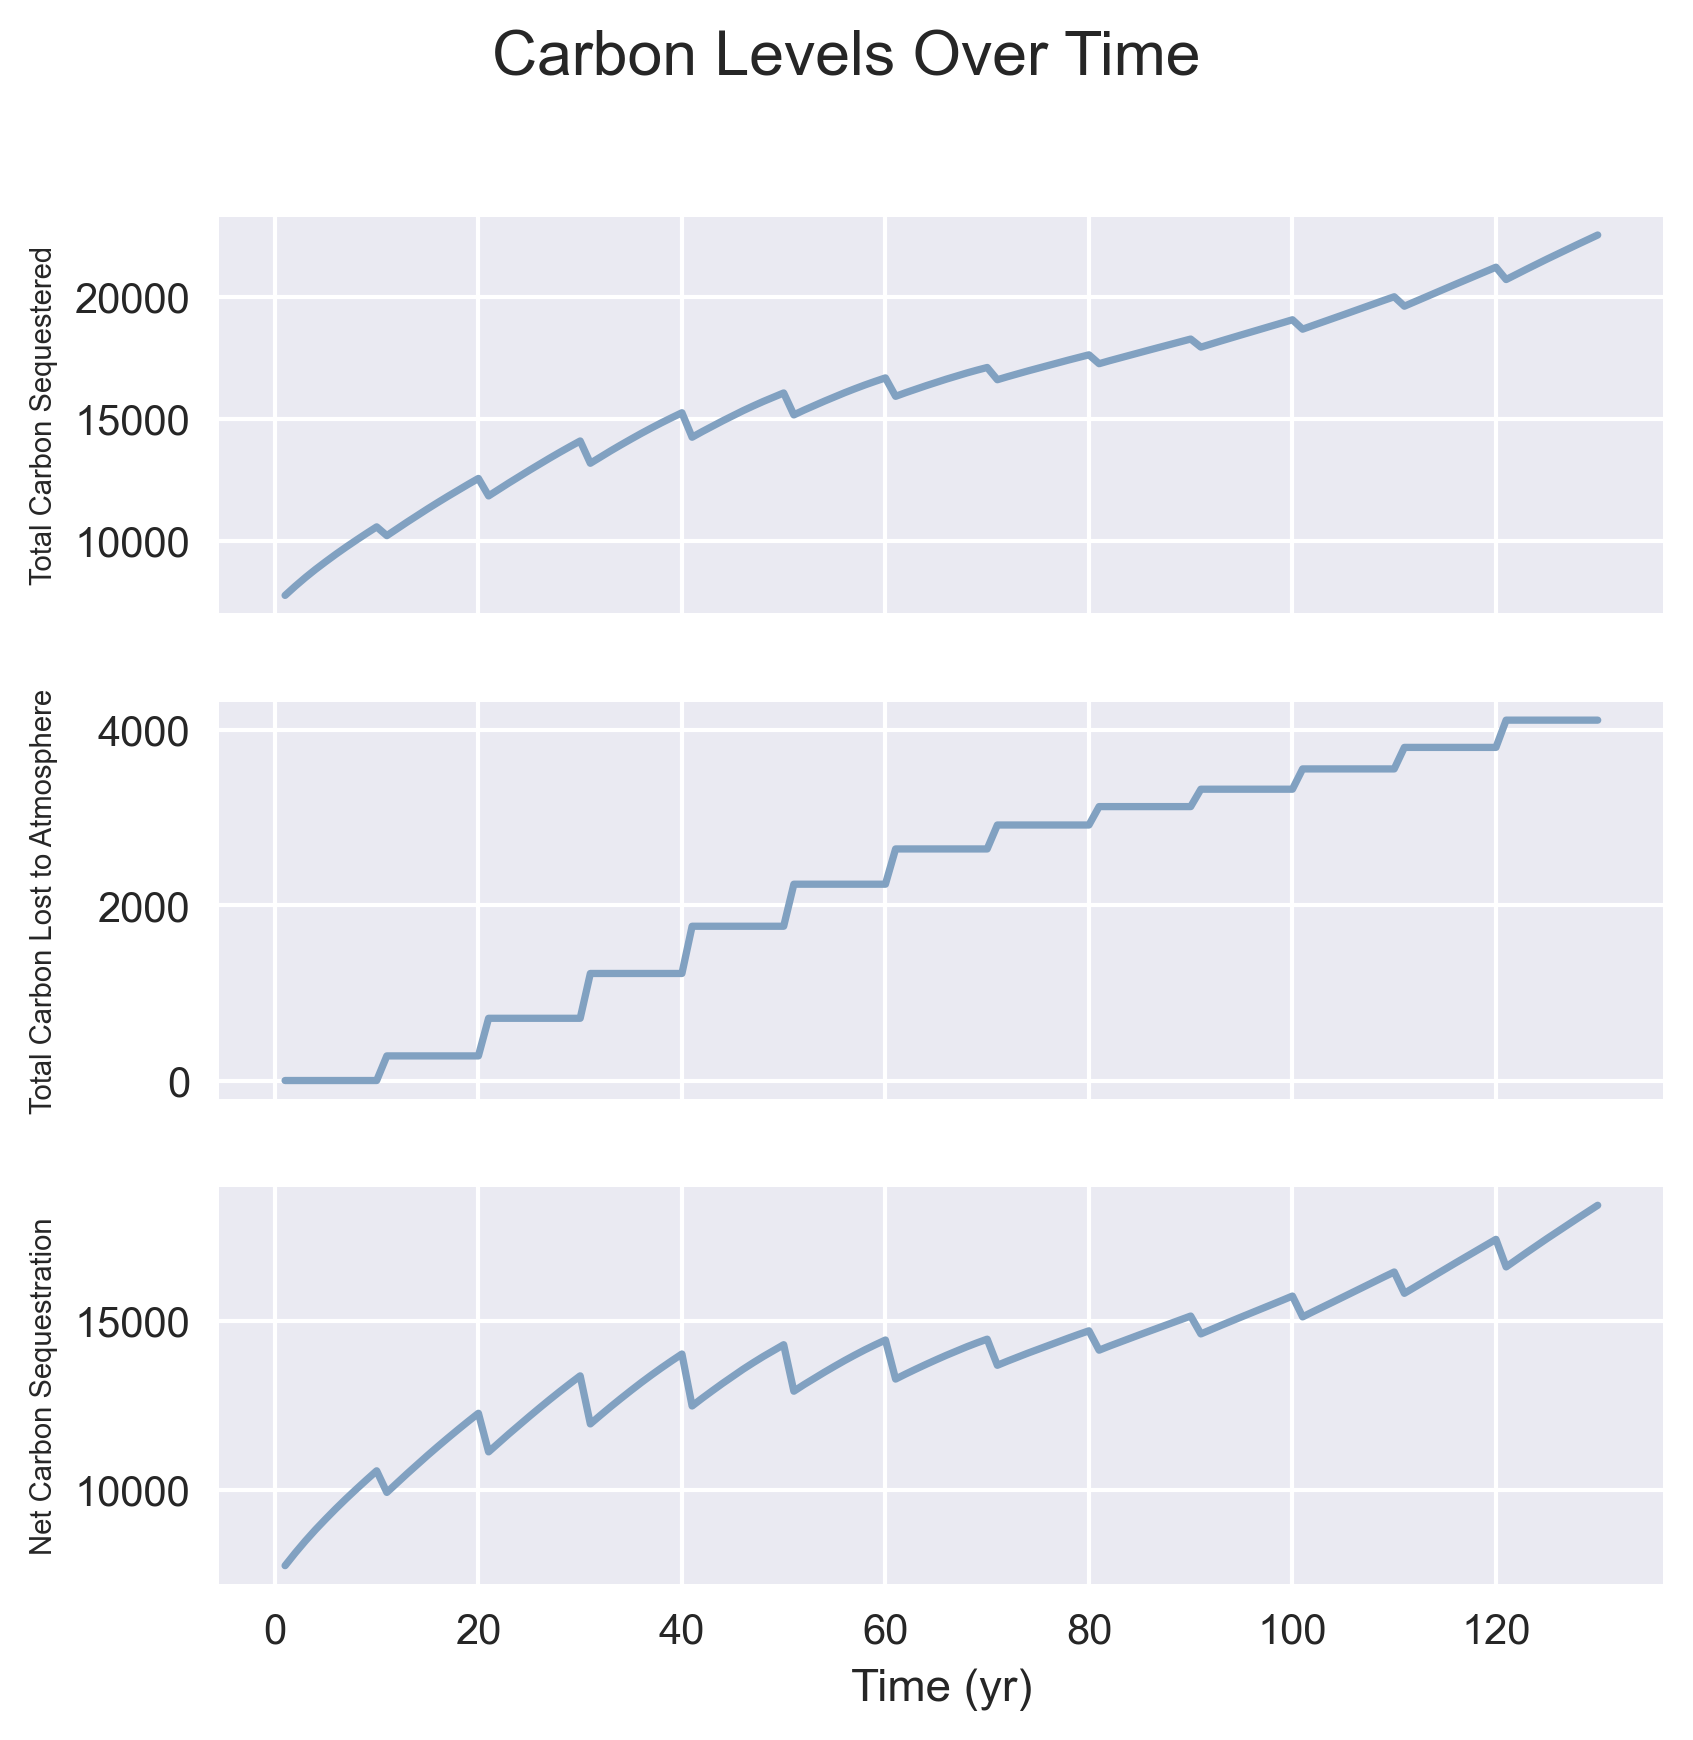

Total Carbon Sequestration: 22547.792548674042
Total Carbon Lost to Atmosphere: 4110.483843249394
Net Sequestration: 18437.30870542465


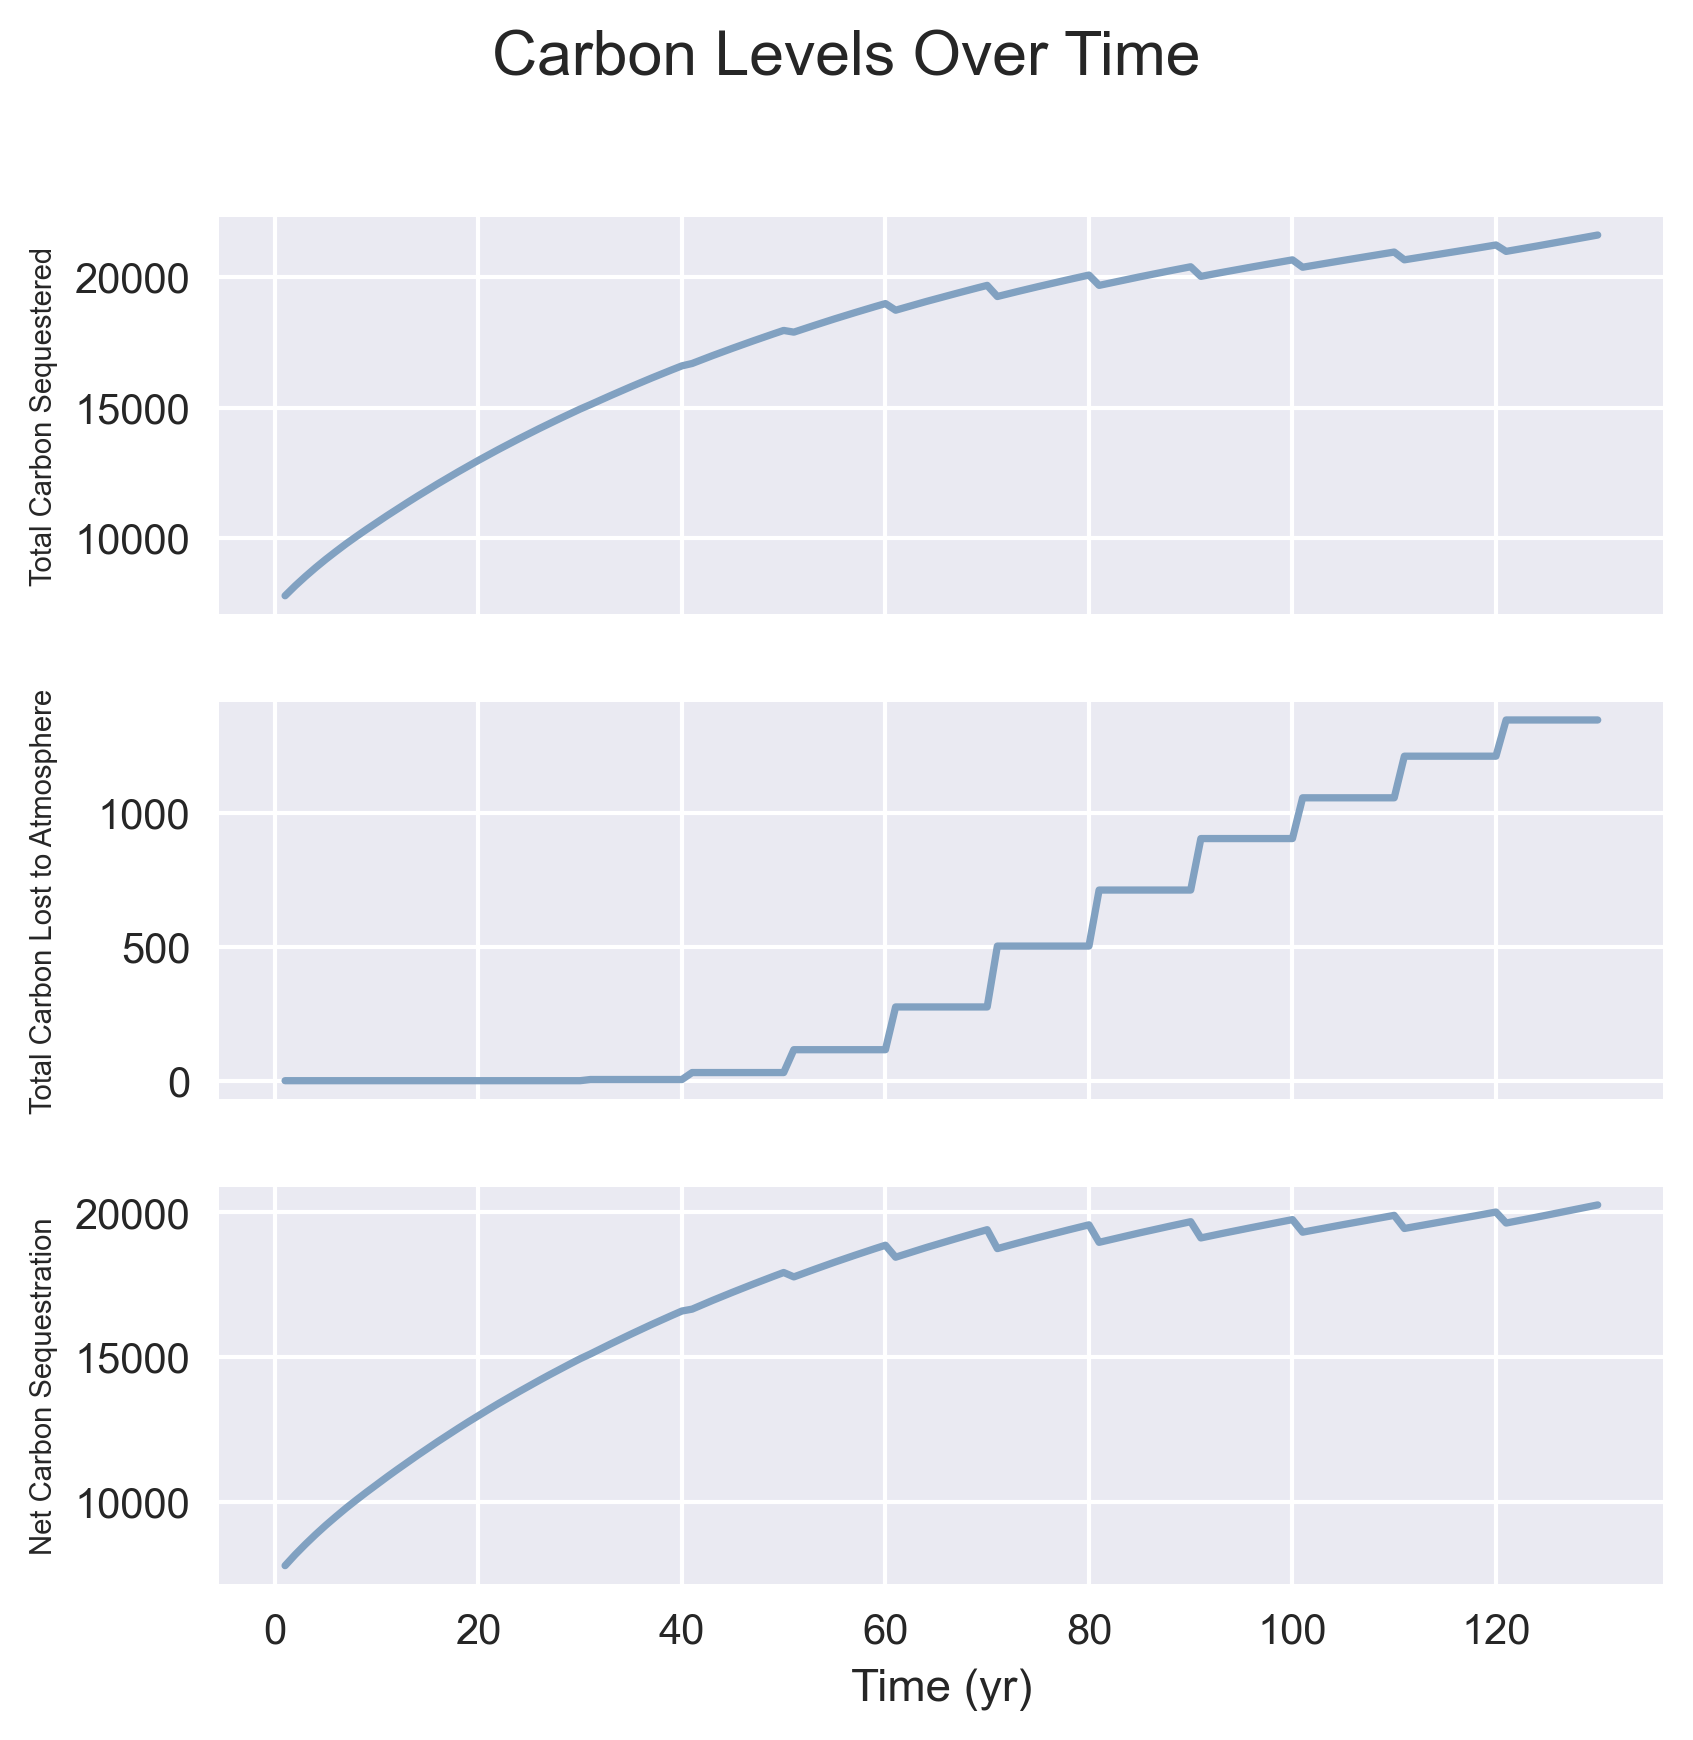

Total Carbon Sequestration: 21609.898323206922
Total Carbon Lost to Atmosphere: 1348.6079225432686
Net Sequestration: 20261.290400663653


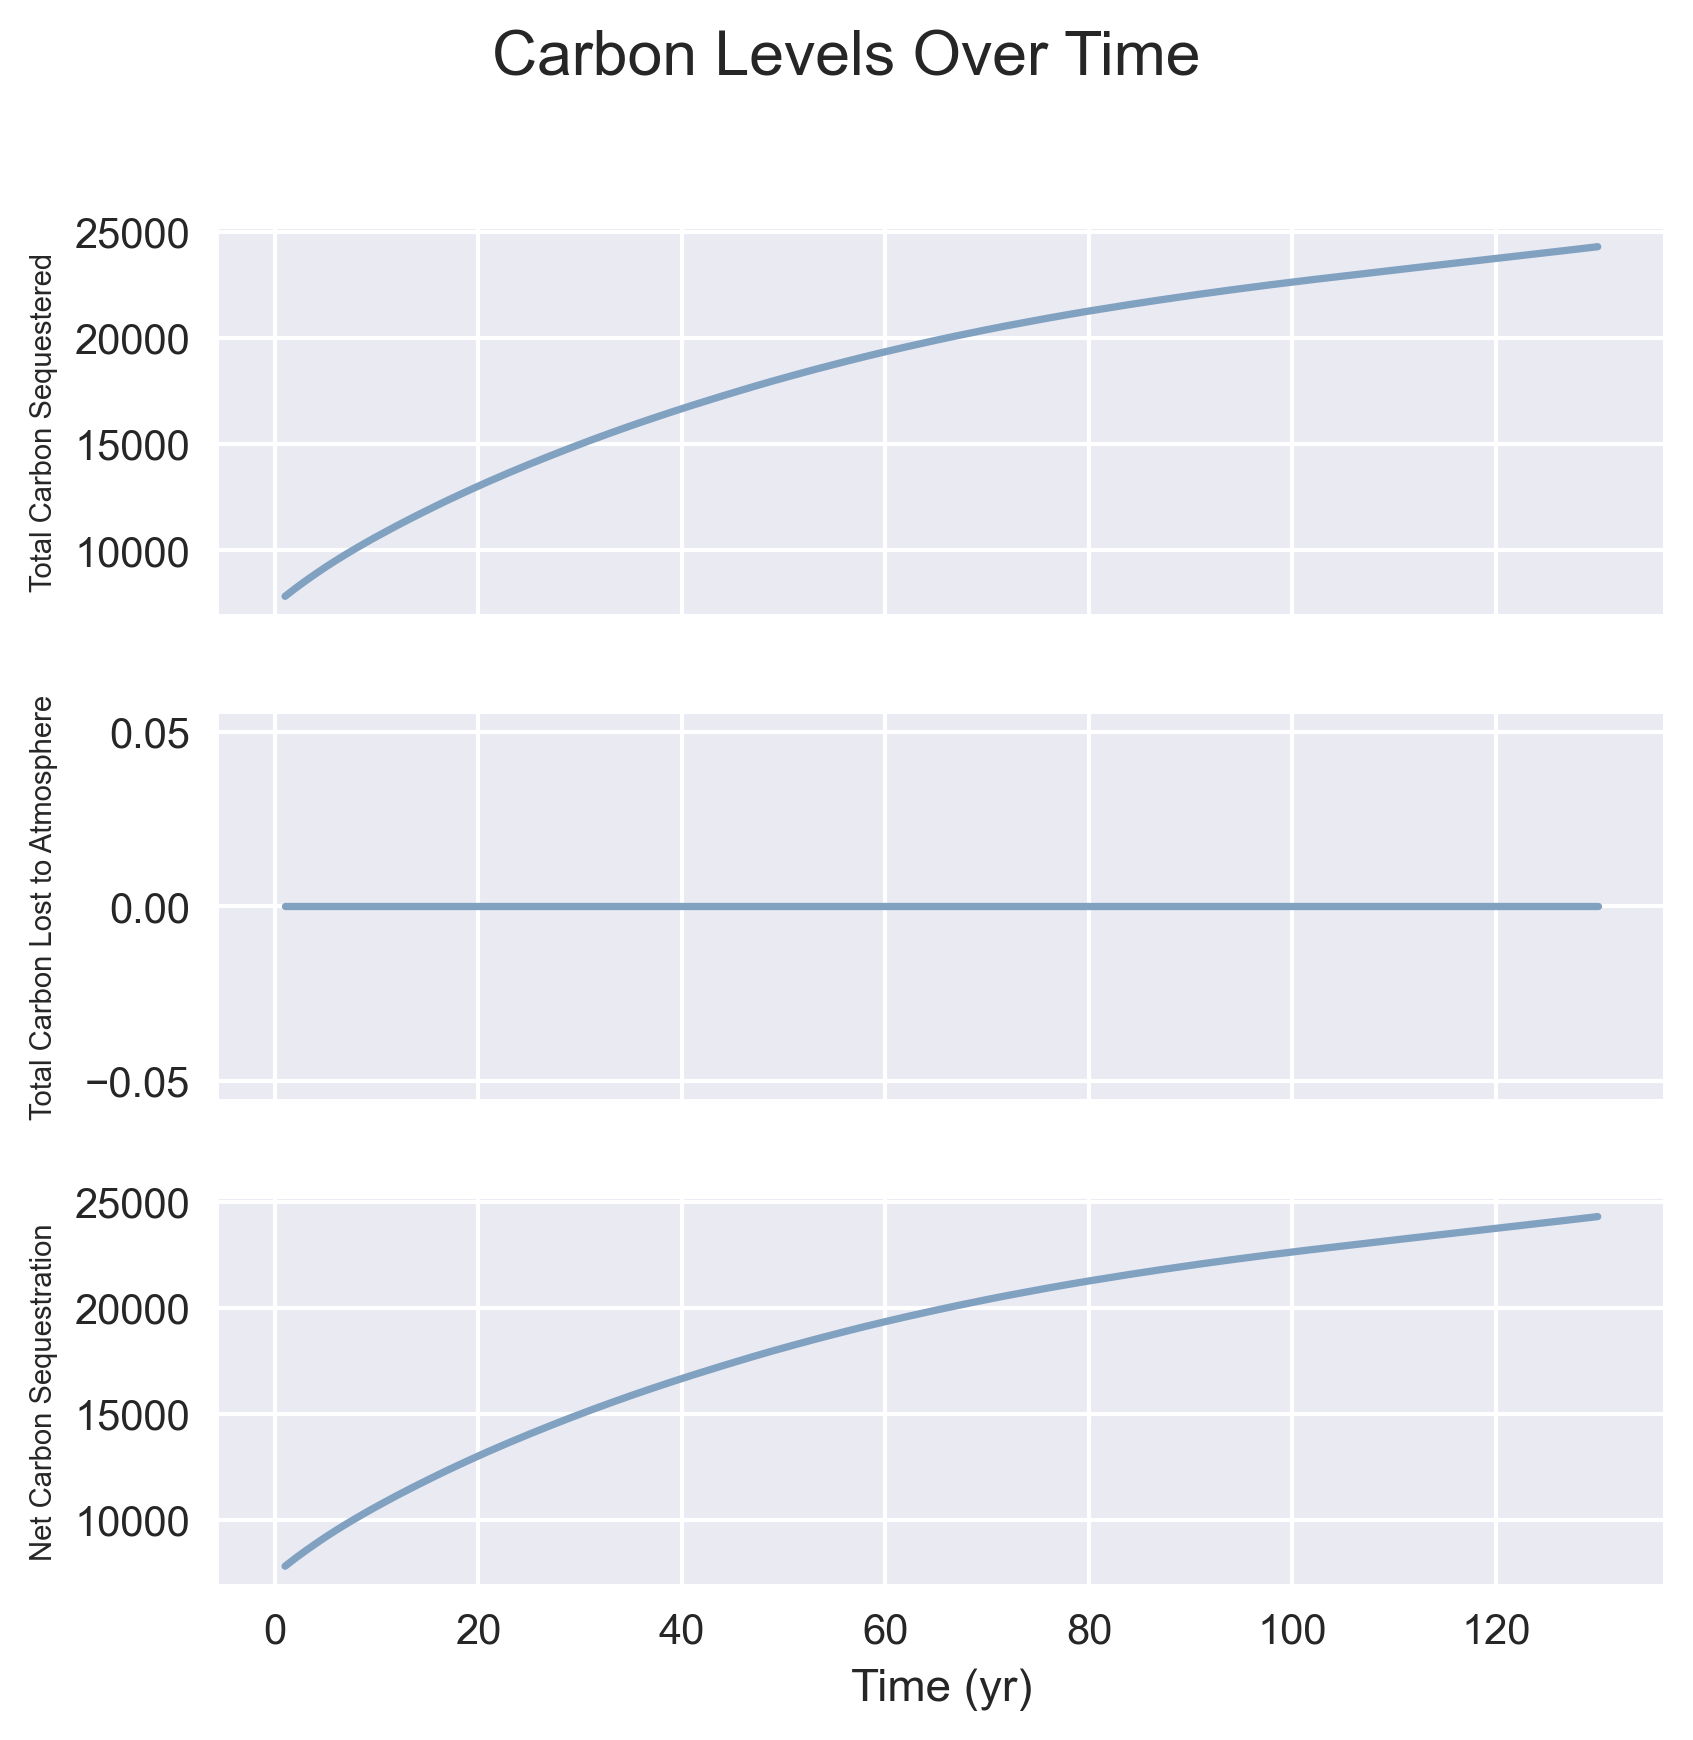

Total Carbon Sequestration: 24302.130834863197
Total Carbon Lost to Atmosphere: 0.0
Net Sequestration: 24302.130834863197


In [8]:
RHO_VALS = [2, 10, 20, 30]
for i in RHO_VALS:
    tropical = Tropical(100, 130, "test", False, i, 2.3, 10, ftype="Tropical")
    tropical.simulate()

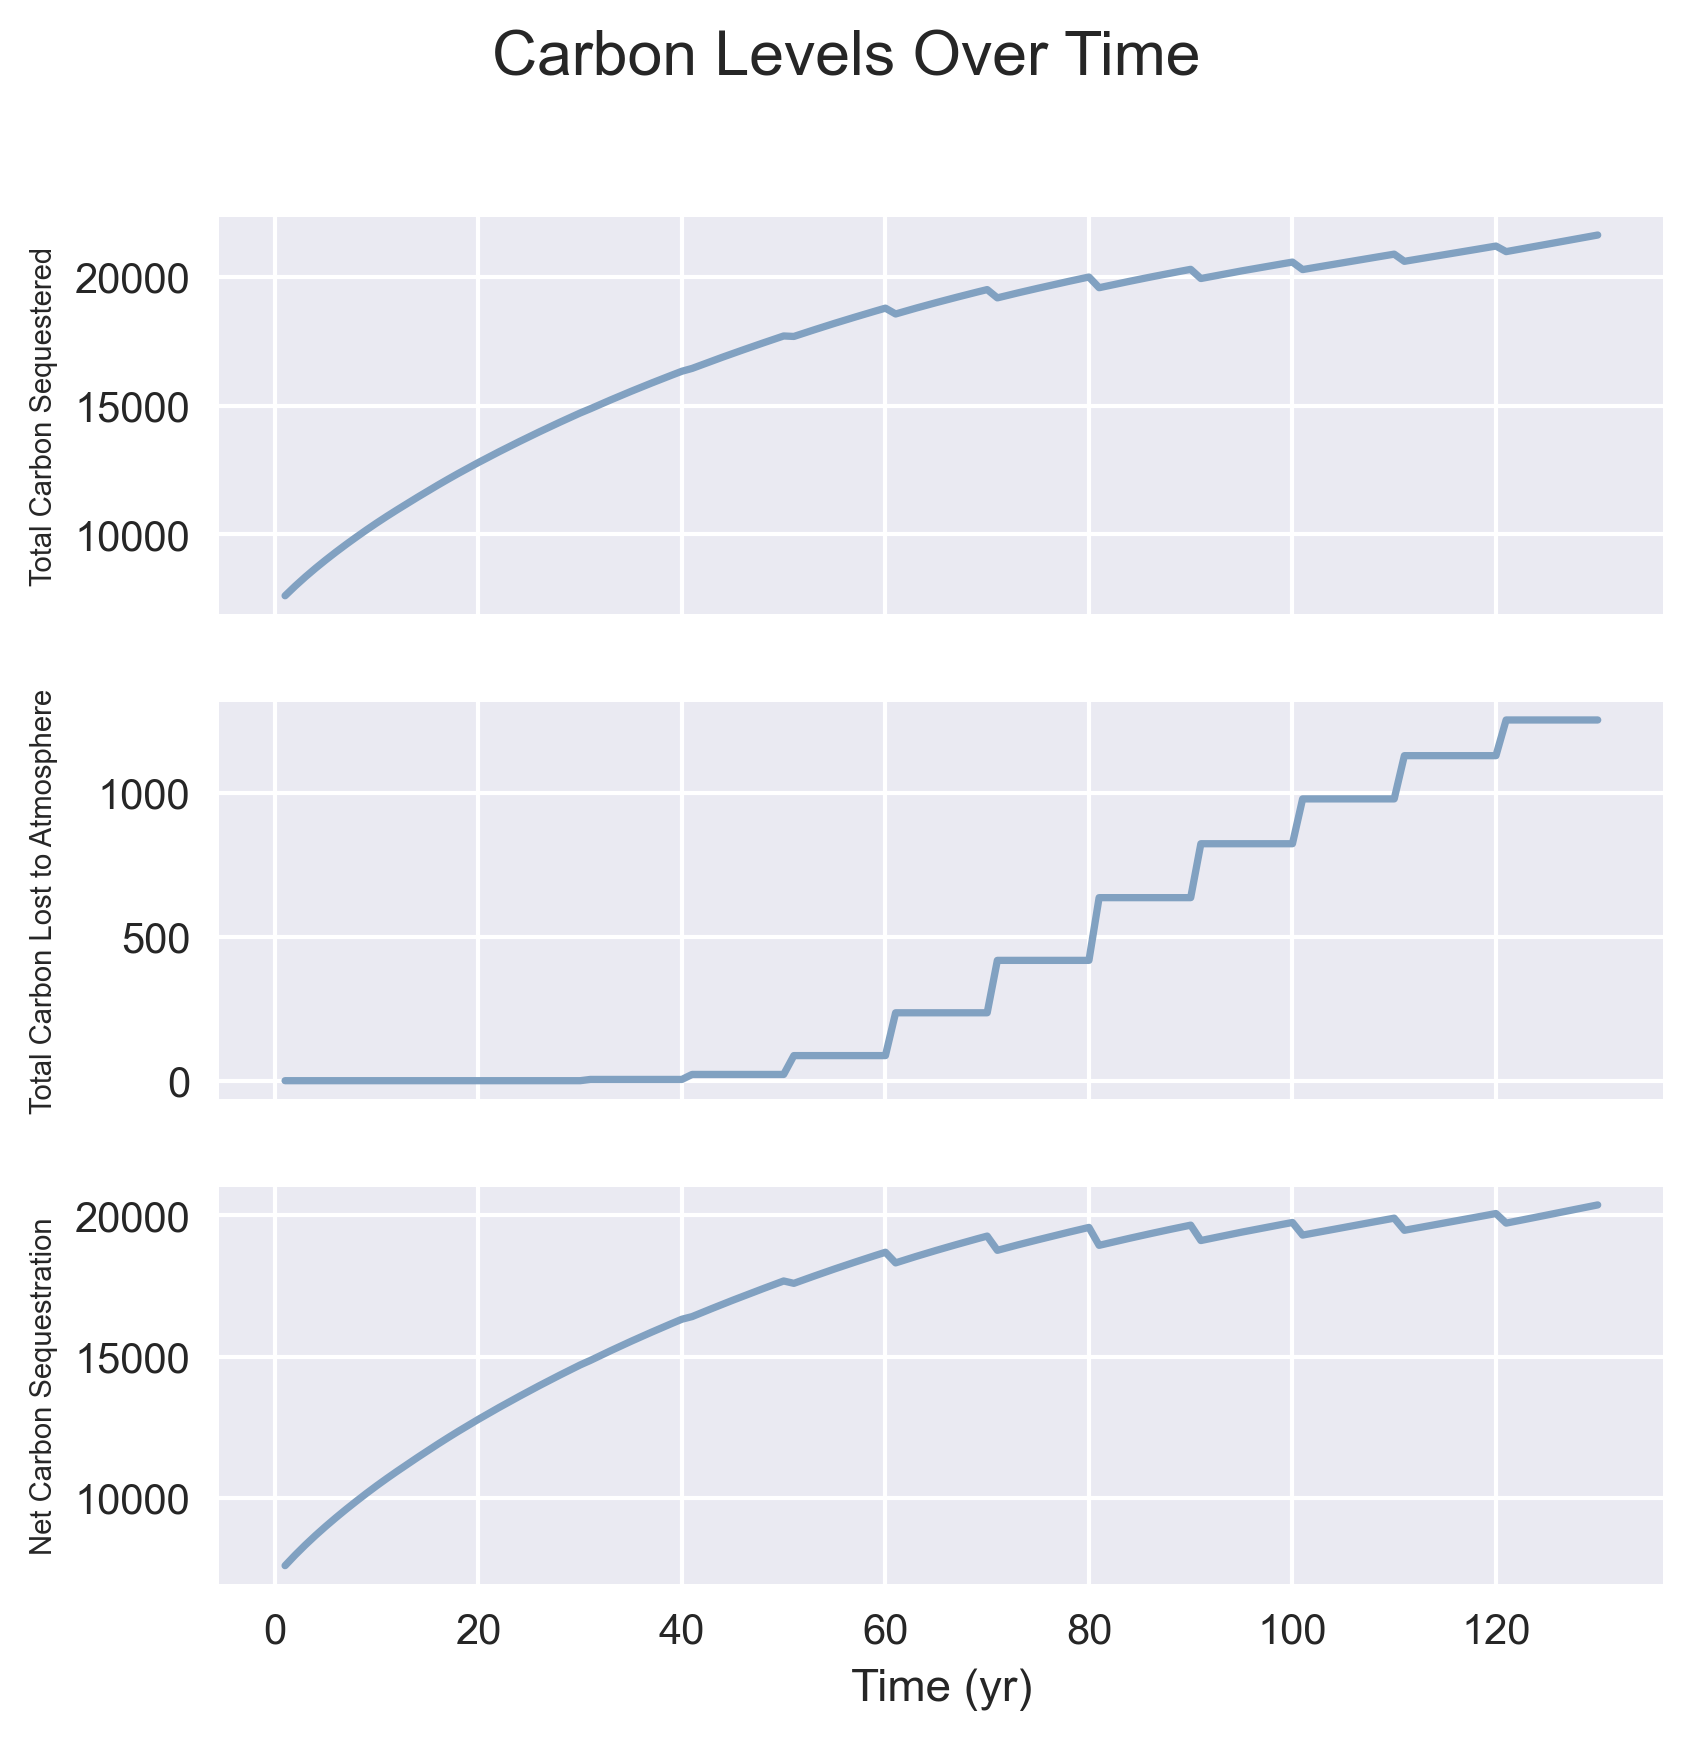

Total Carbon Sequestration: 21623.927741651252
Total Carbon Lost to Atmosphere: 1251.7128620023536
Net Sequestration: 20372.2148796489


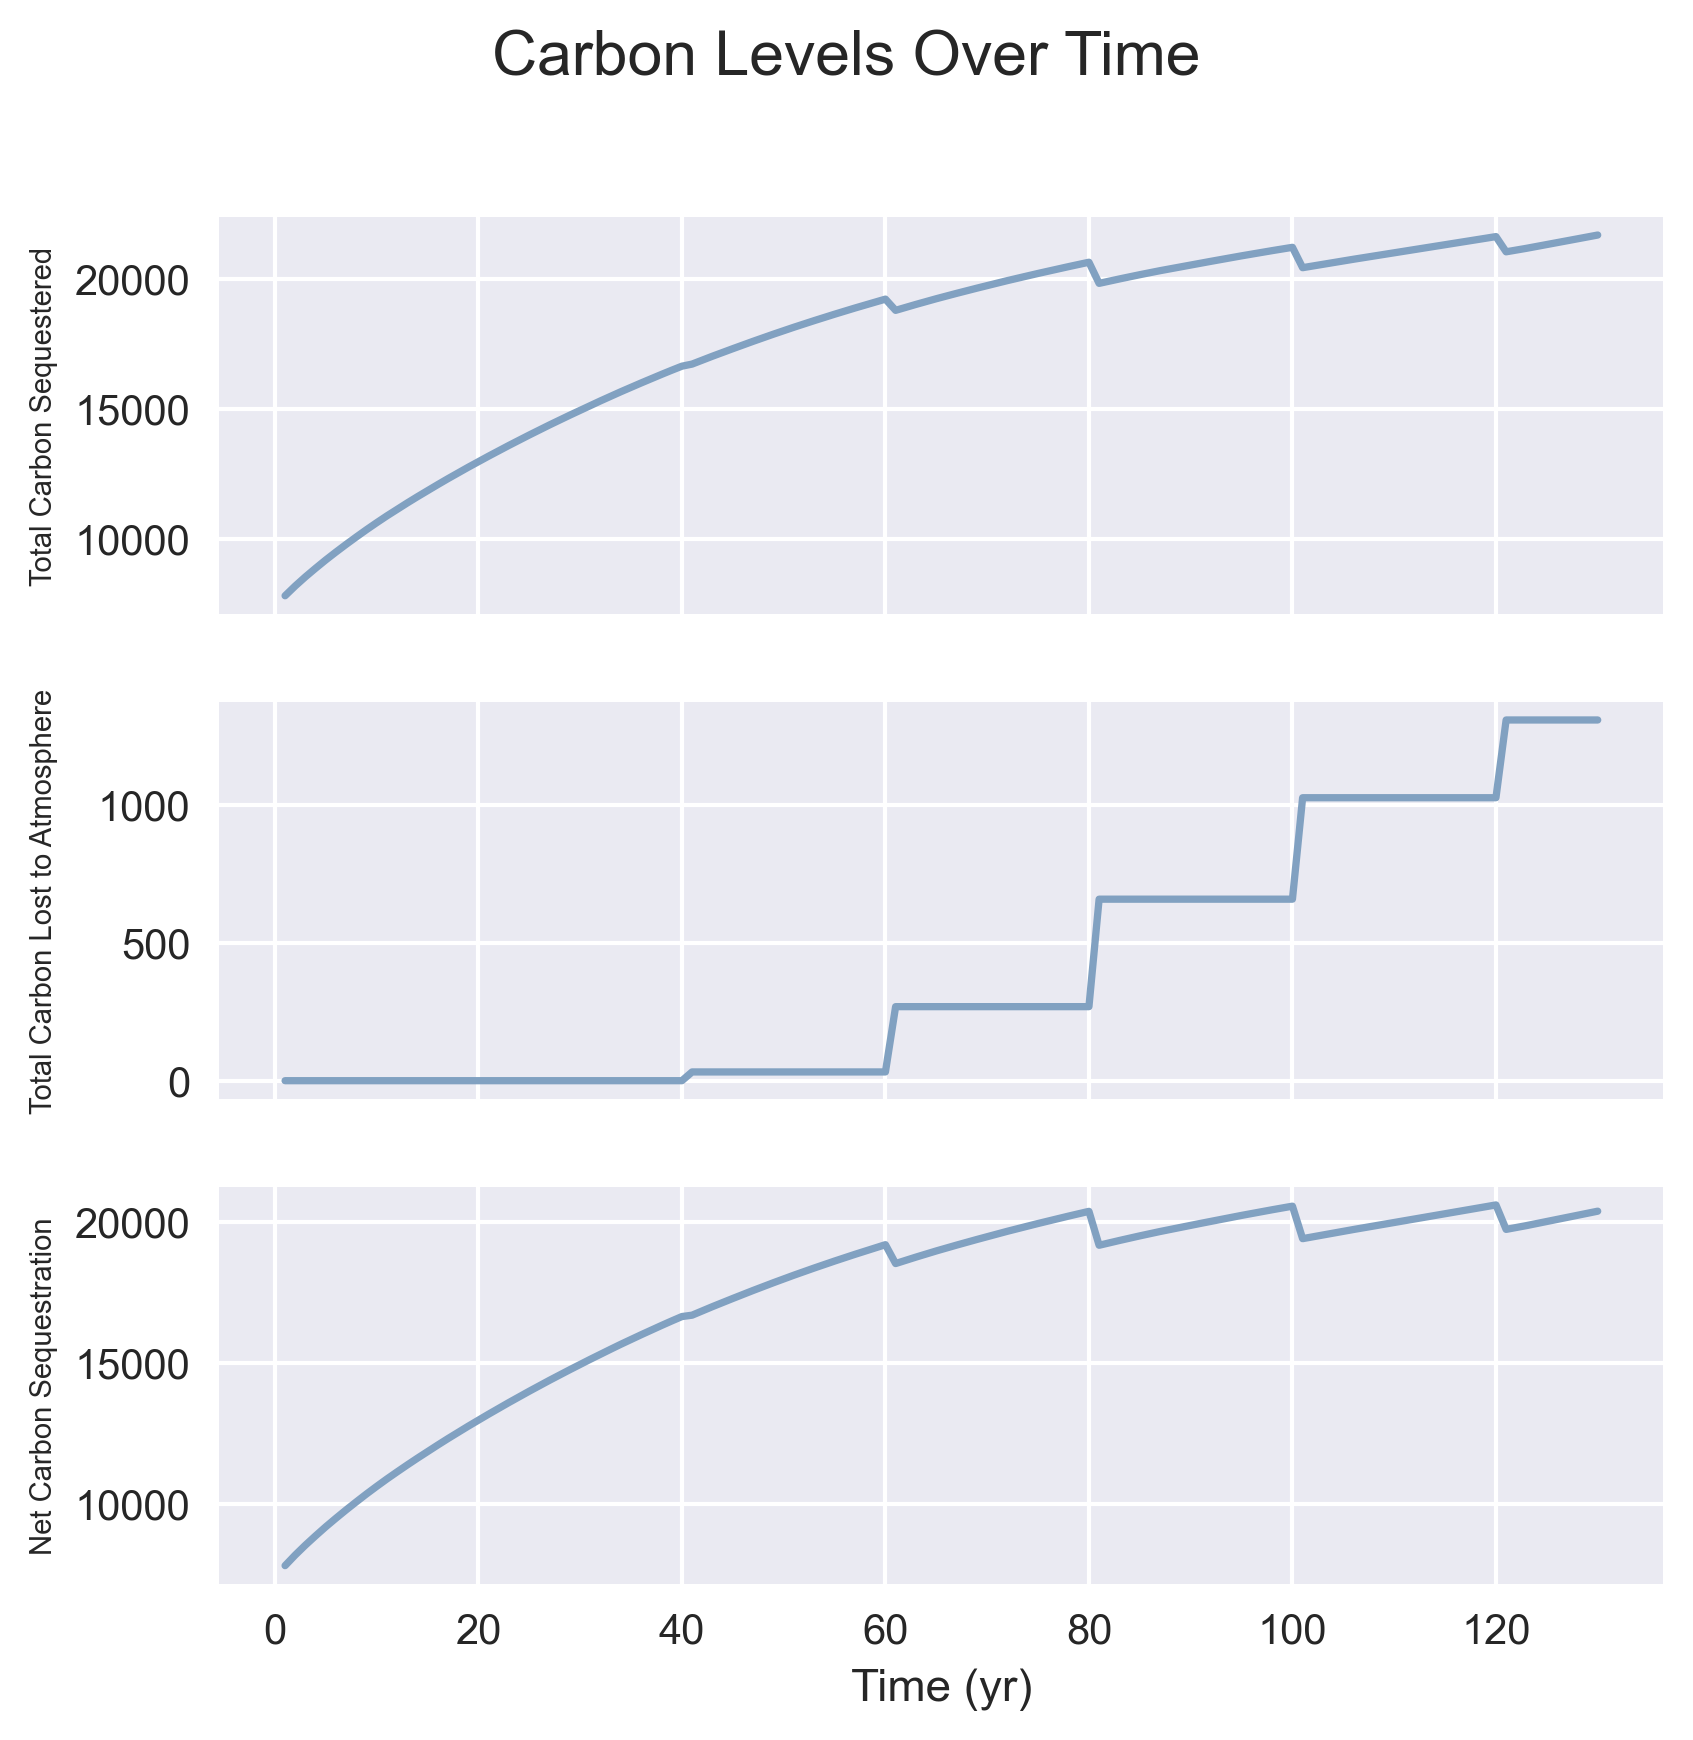

Total Carbon Sequestration: 21702.20916659037
Total Carbon Lost to Atmosphere: 1309.6262426262595
Net Sequestration: 20392.582923964113


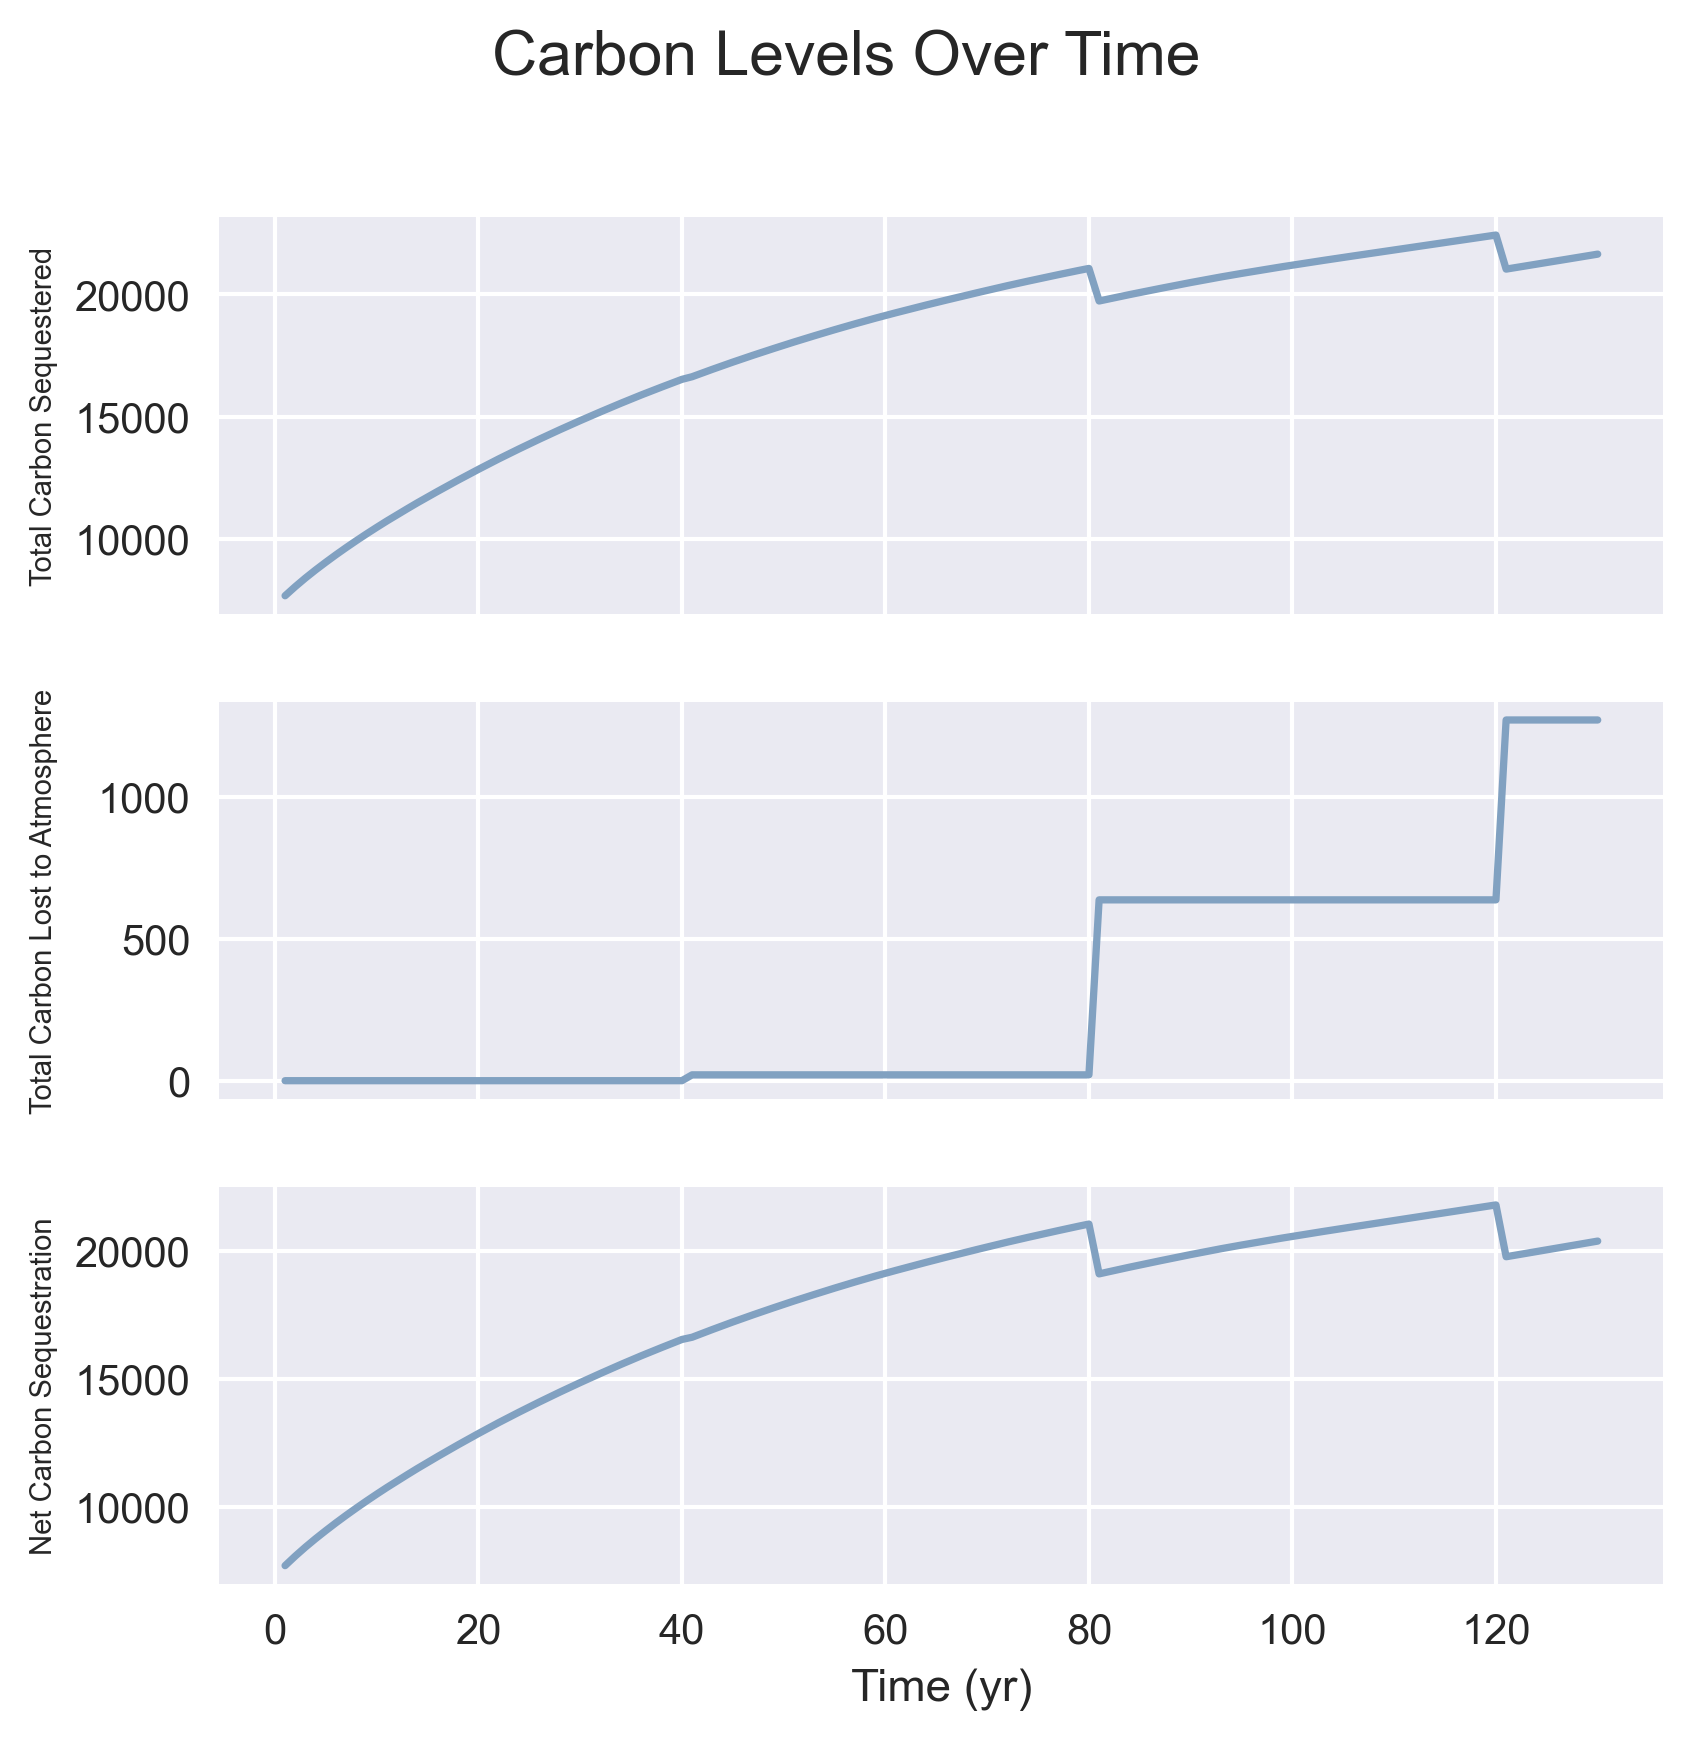

Total Carbon Sequestration: 21641.51418500012
Total Carbon Lost to Atmosphere: 1269.4237366169232
Net Sequestration: 20372.0904483832


In [9]:
MGM_VALS = [10, 20, 40]
for i in MGM_VALS:
    tropical = Tropical(100, 130, "test", False, 20, 2.3, i, ftype="Tropical")
    tropical.simulate()

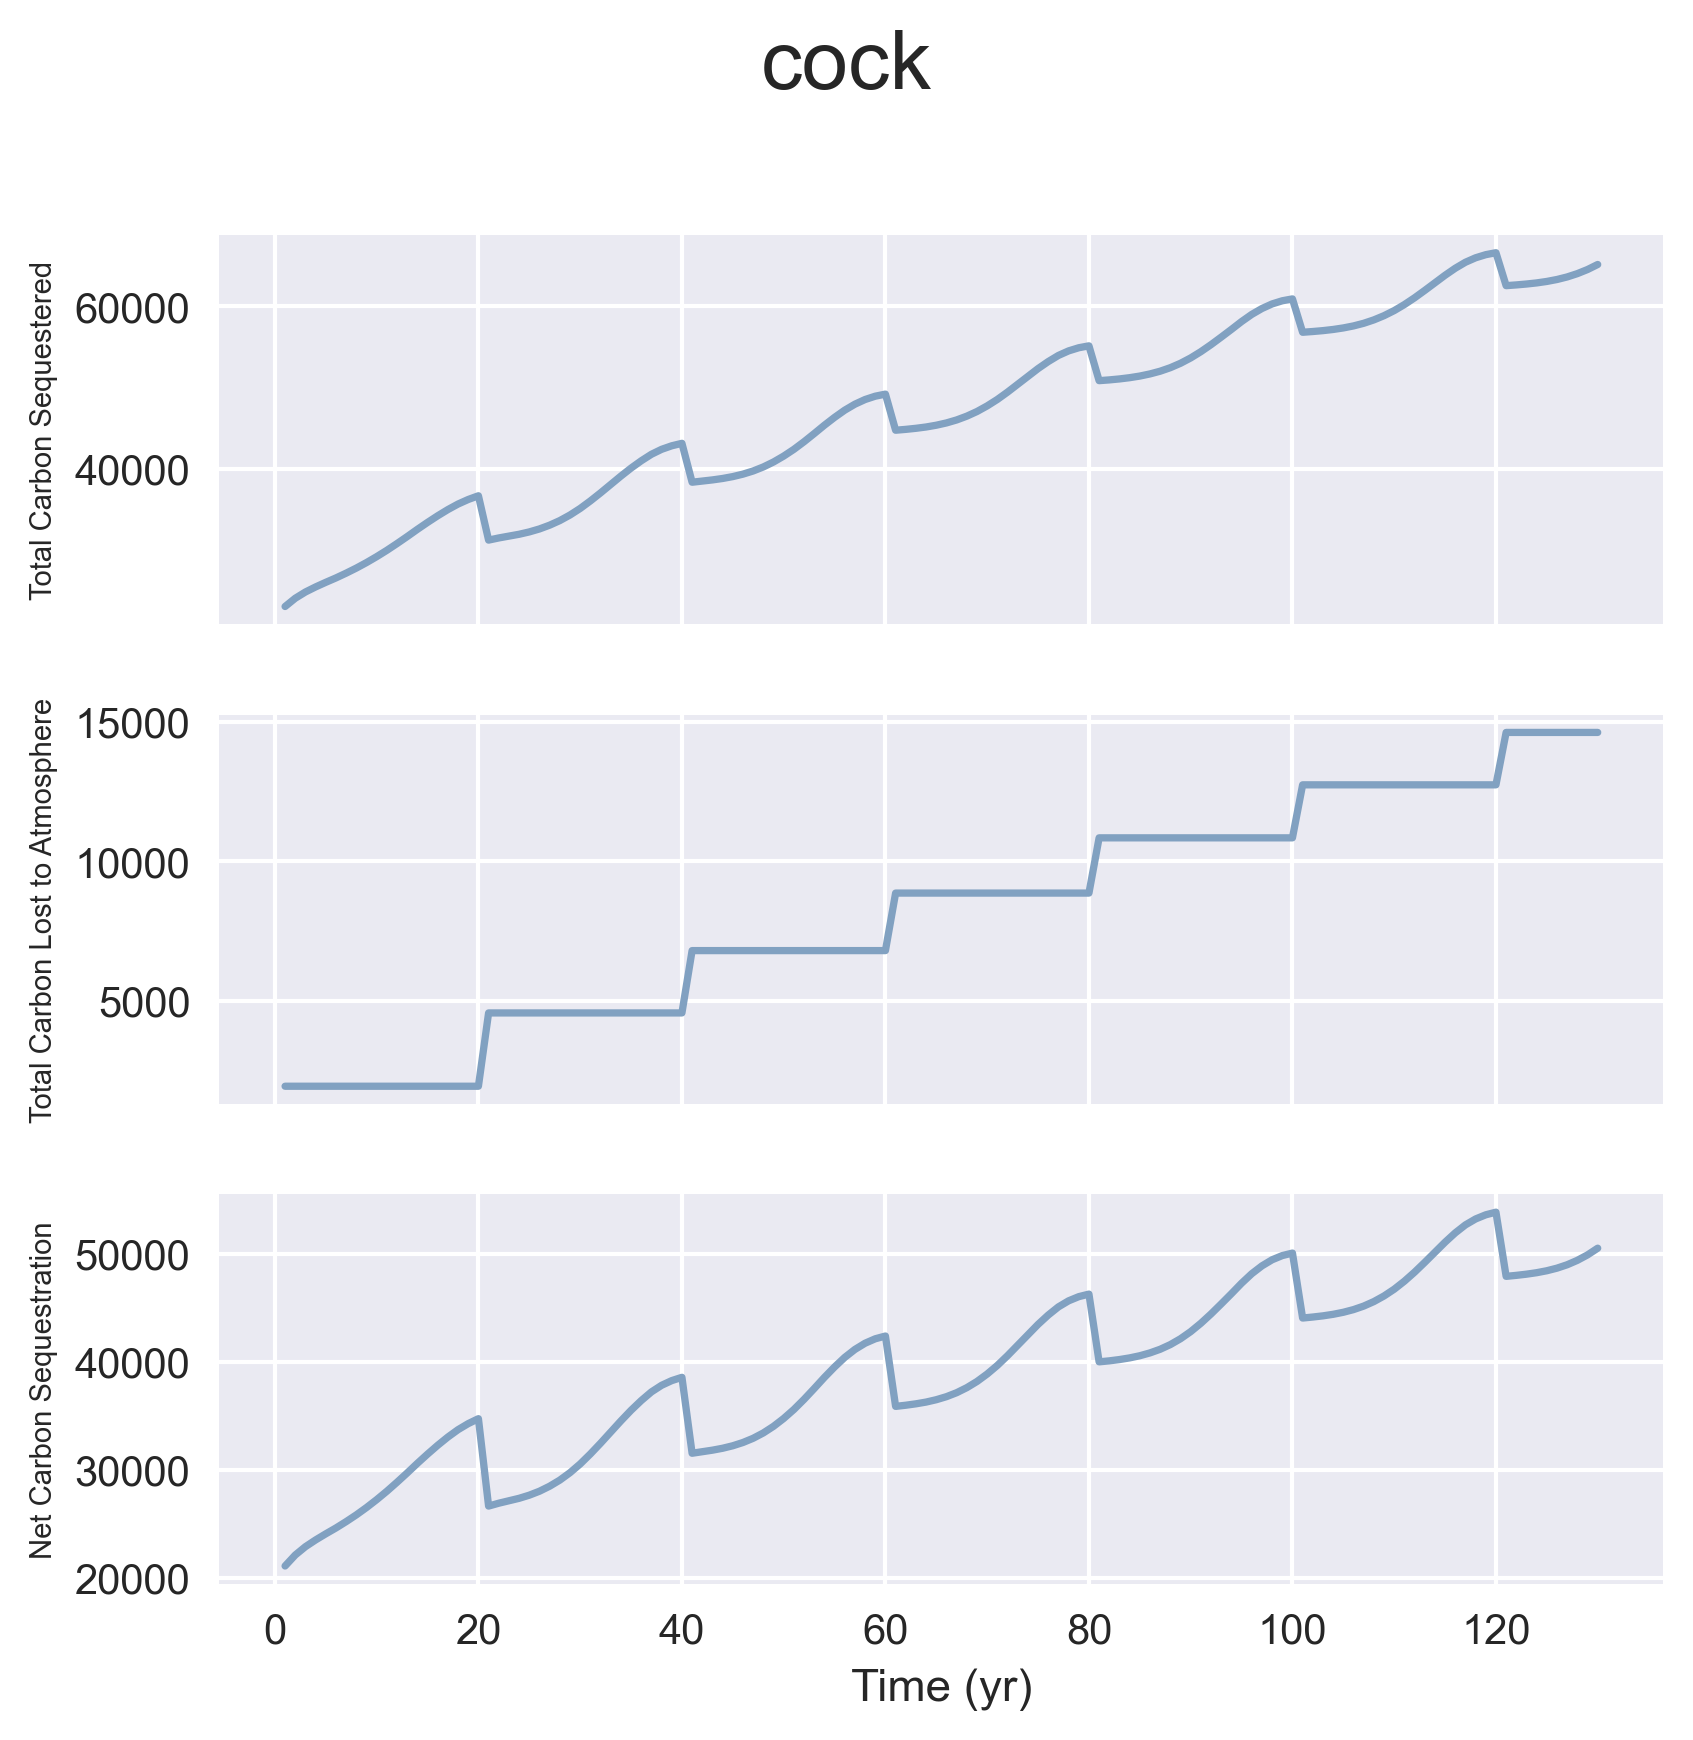

Total Carbon Sequestration: 65175.604785194475
Total Carbon Lost to Atmosphere: 14636.716607523844
Net Sequestration: 50538.88817767063


In [4]:
boreal = Boreal(100, 130, "test", False, 20, 2.3, 20, ftype="Boreal")
boreal.simulate()

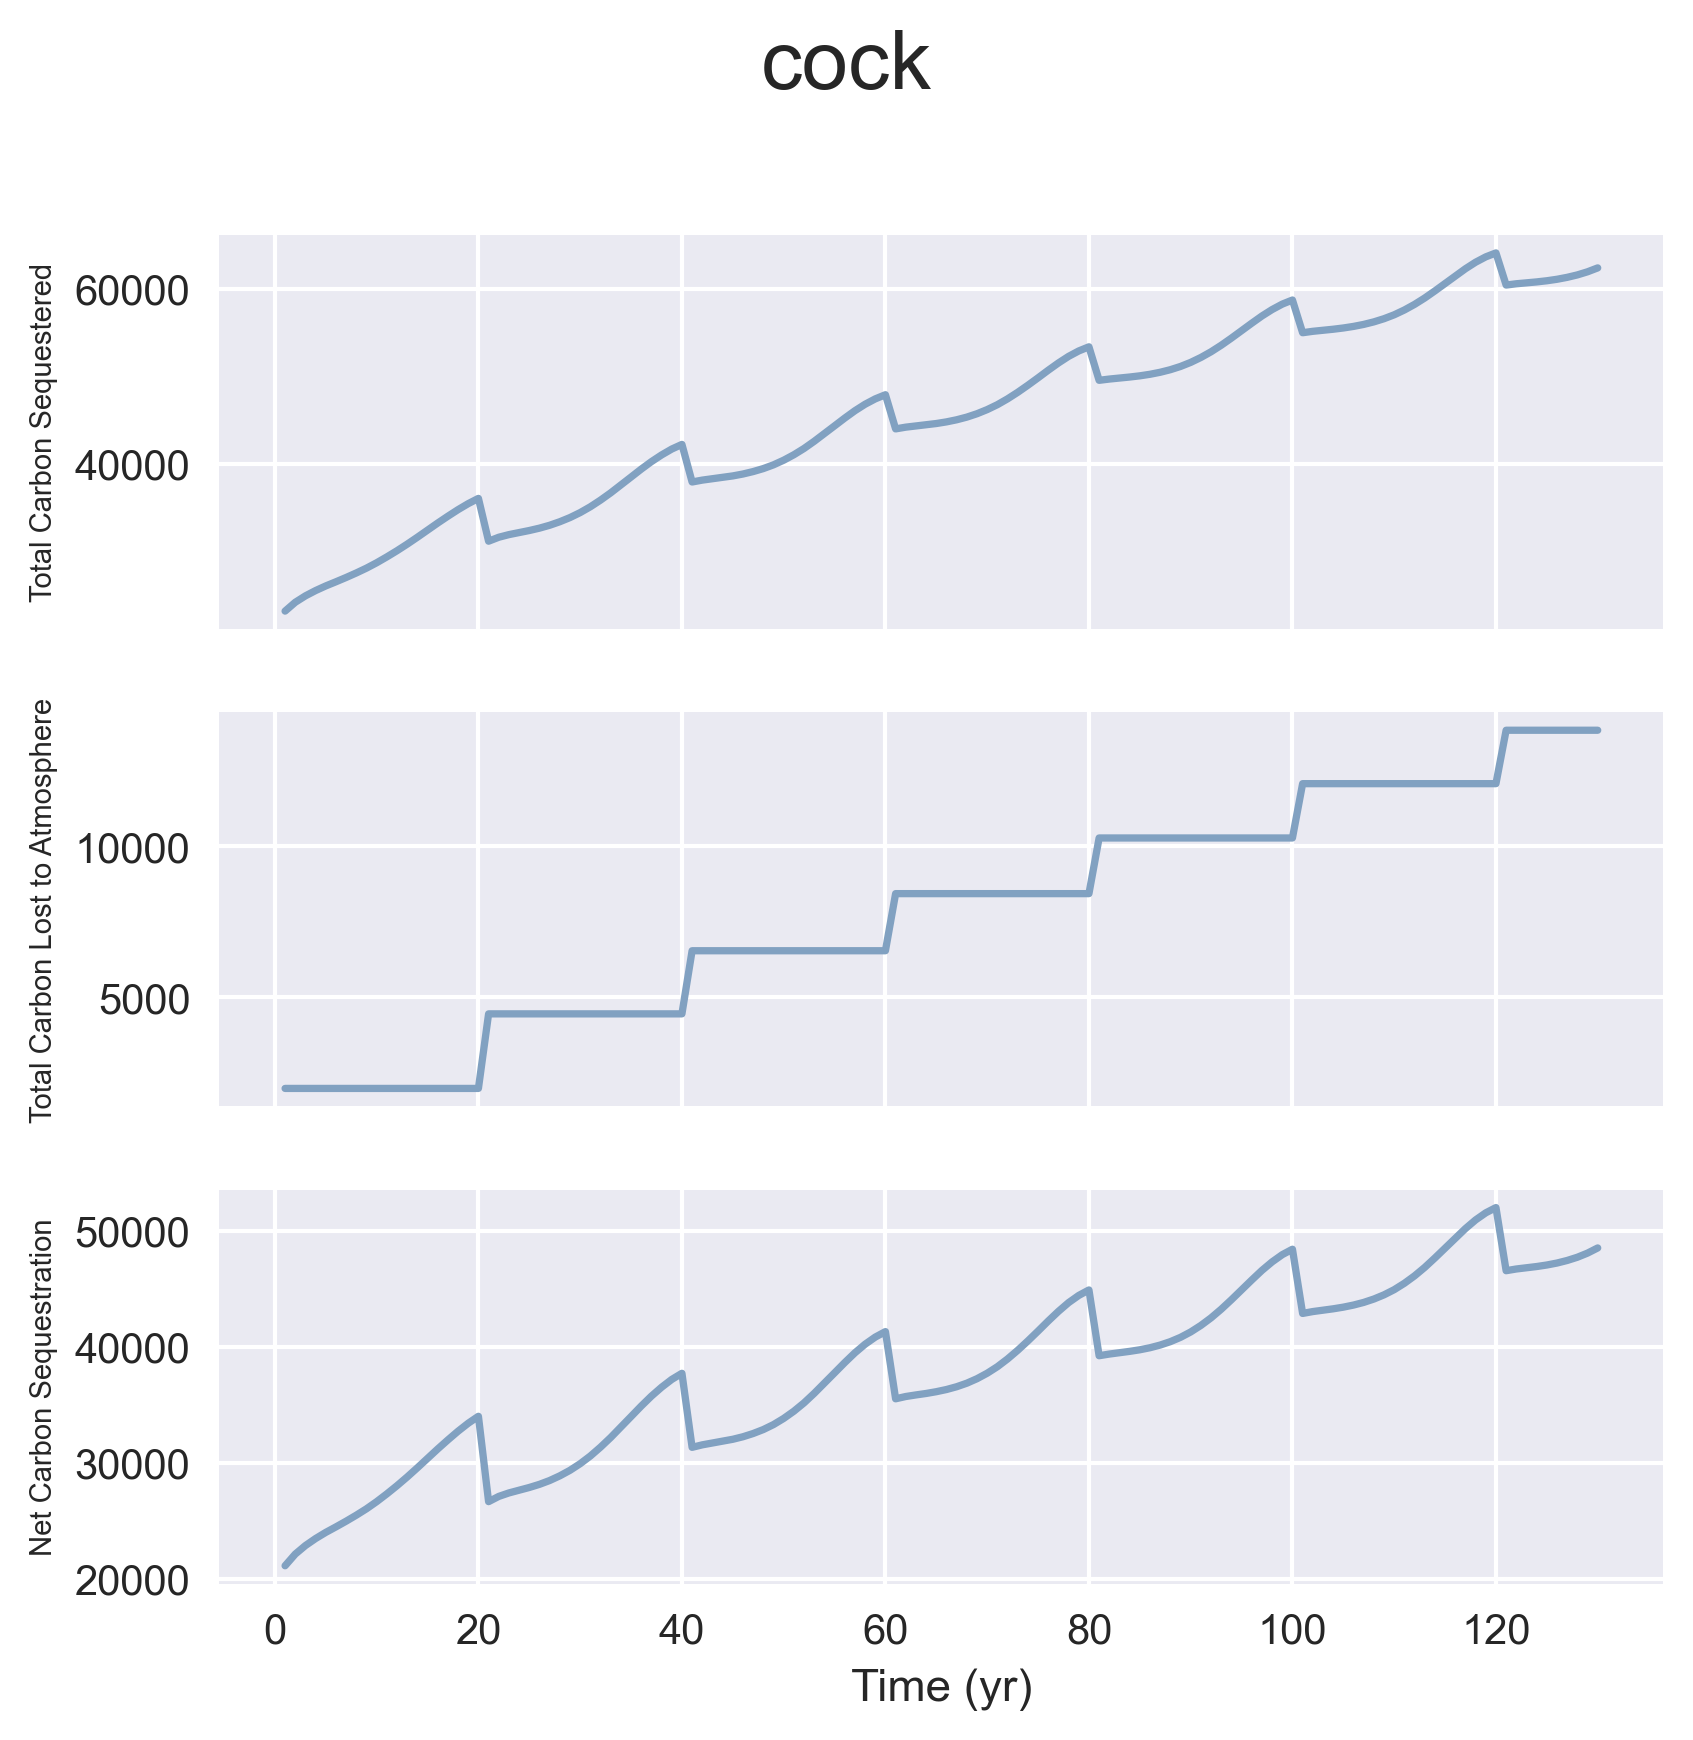

Total Carbon Sequestration: 62404.1373990252
Total Carbon Lost to Atmosphere: 13846.412141340921
Net Sequestration: 48557.72525768428


In [5]:
temperate = Temperate(100, 130, "test", False, 20, 2.3, 20, ftype="Temperate")
temperate.simulate()

In [ ]:
temperate = Temperate(100, 130, "test", False, 100, 2.3, 20, ftype="Temperate")
temperate.simulate()

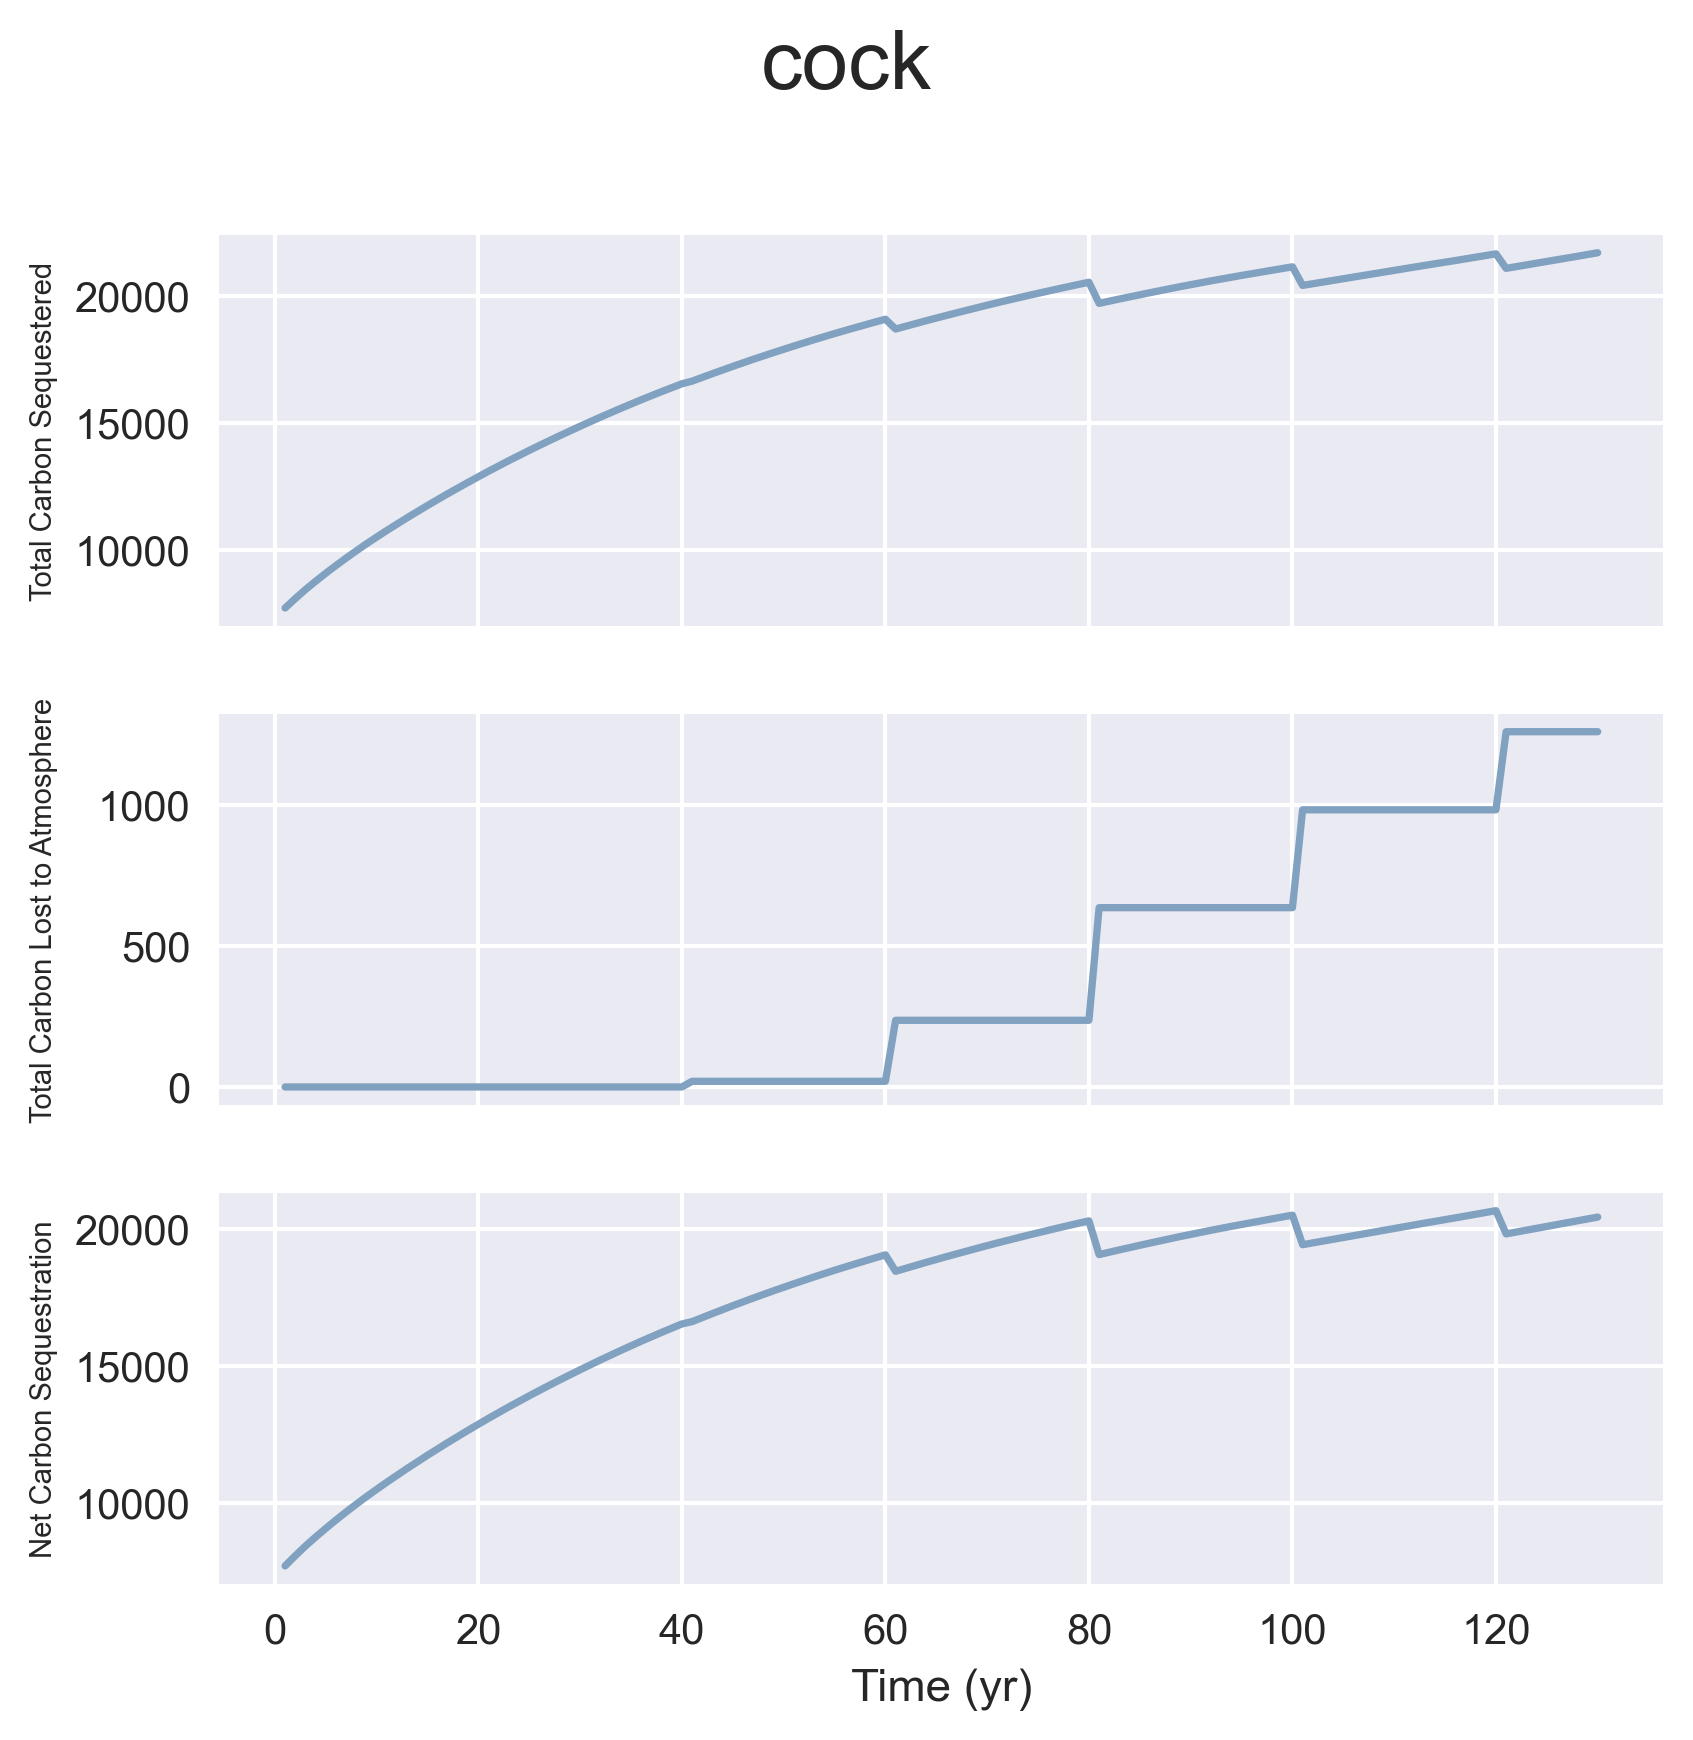

Total Carbon Sequestration: 21692.157046046057
Total Carbon Lost to Atmosphere: 1259.7978072005687
Net Sequestration: 20432.35923884549


In [6]:
tropical = Tropical(100, 130, "test", False, 20, 2.3, 20, ftype="Tropical")
tropical.simulate()

In [ ]:
tropical = Tropical(100, 130, "test", False, 30, 2.3, 20, ftype="Tropical")
tropical.simulate()